In [14]:
import numpy as np
import pandas as pd
from functools import reduce
import time
import sys
import os   
import re
import importlib
import math
from datetime import datetime    
import sklearn
from sklearn import preprocessing
from scipy.spatial import Delaunay
from scipy import stats
from scipy import signal
from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from statannot import add_stat_annotation


%matplotlib widget



## To do:
- _(ask Andy about animal frame and joint axis polarity)_ Says pronation + supination -, yes re animal vector
- for Rob:
    - 2 csvs: 1 for ROM and 1 for kinematics, with uid and species columns as well as 6DOF for acromion, glenoid, and elbow
        - keep order
    - export moment arms and moments
- _redo ch4 plots to show pooled stats_
- _add grid to back wall of sprawling space_
- get humeral volumes and scale MMAs to those
- write resampling analysis for ROM data
- _revist tegu 1, figure out why it's different_
    - maybe also revisit possum 1 low, it's very fast
    - tegu 1 turns head to right!
- _calculate parasagittality metric_
    - _need to export joint translations in world frame or forceplate frame_
- _use overall displacement vector for animal frame_
    - _redo widths_
    - _revisit local GRF vector_
- rob used +-90 from his neutral pose
- check stiffness
- try widths from animal vector
- calculate power



## Definitions

### Rig ref
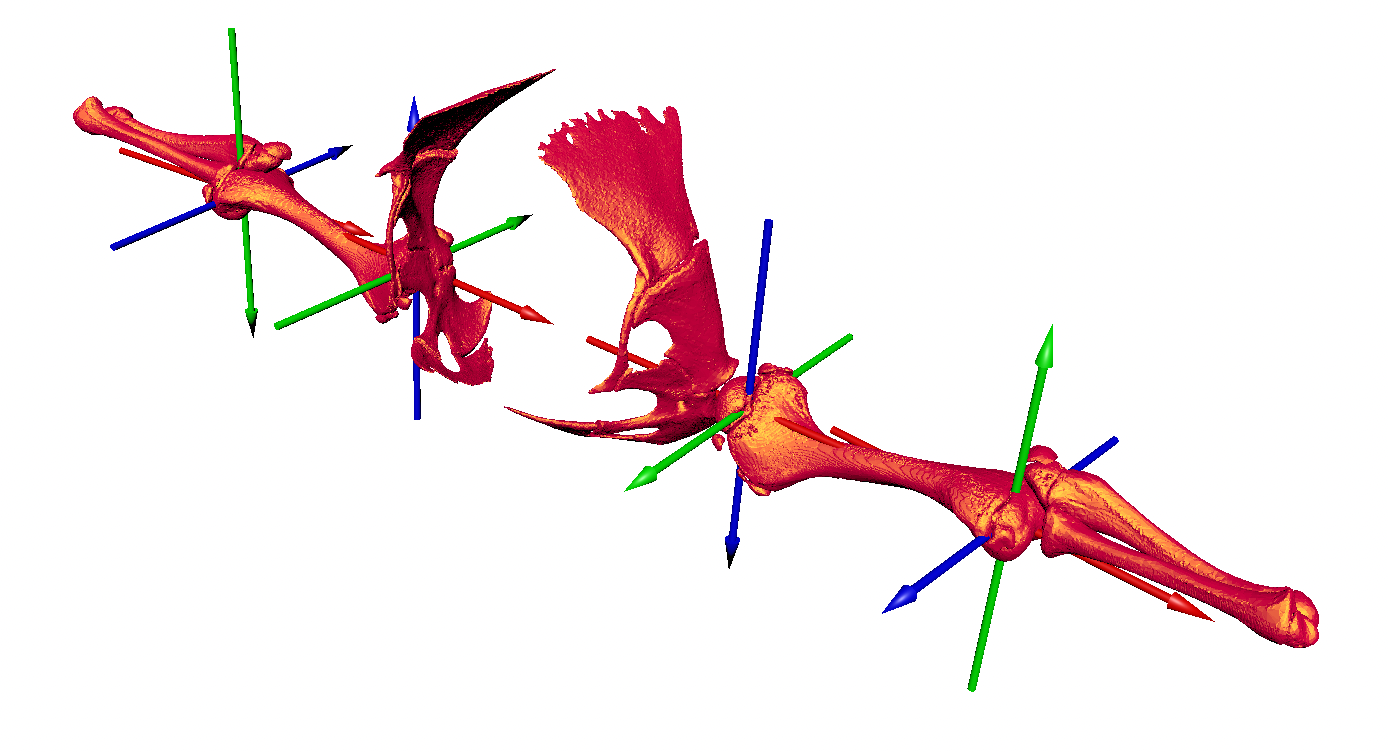
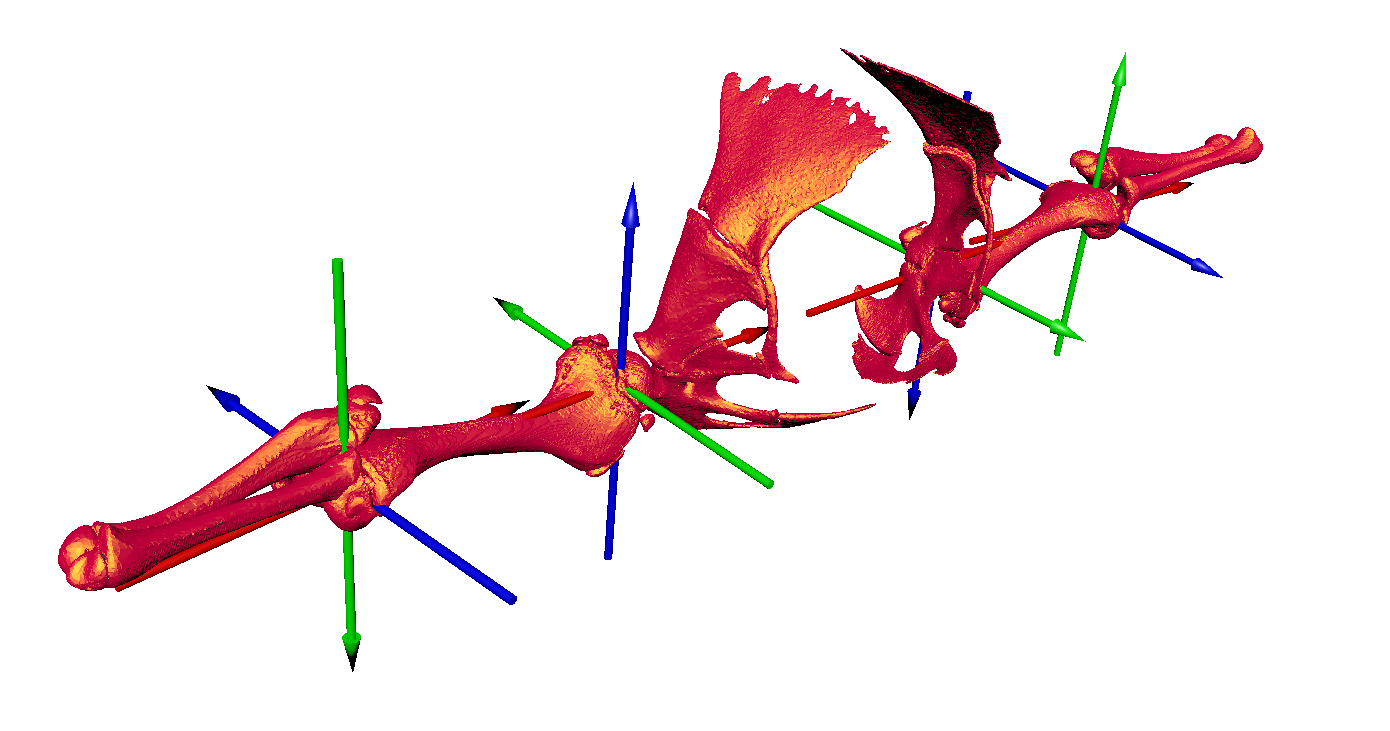
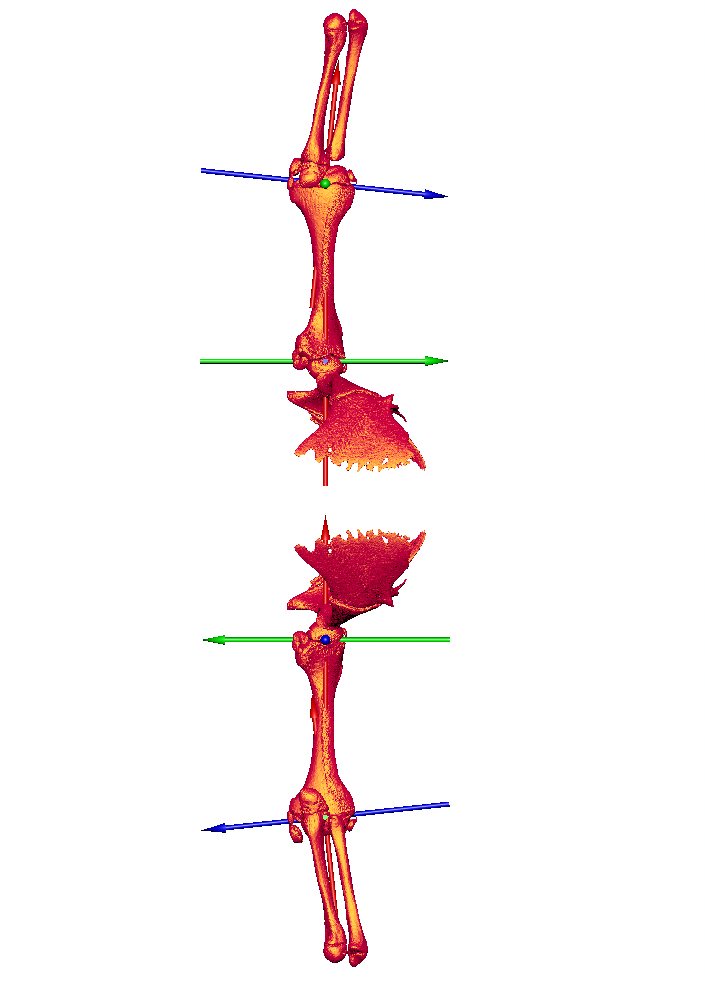
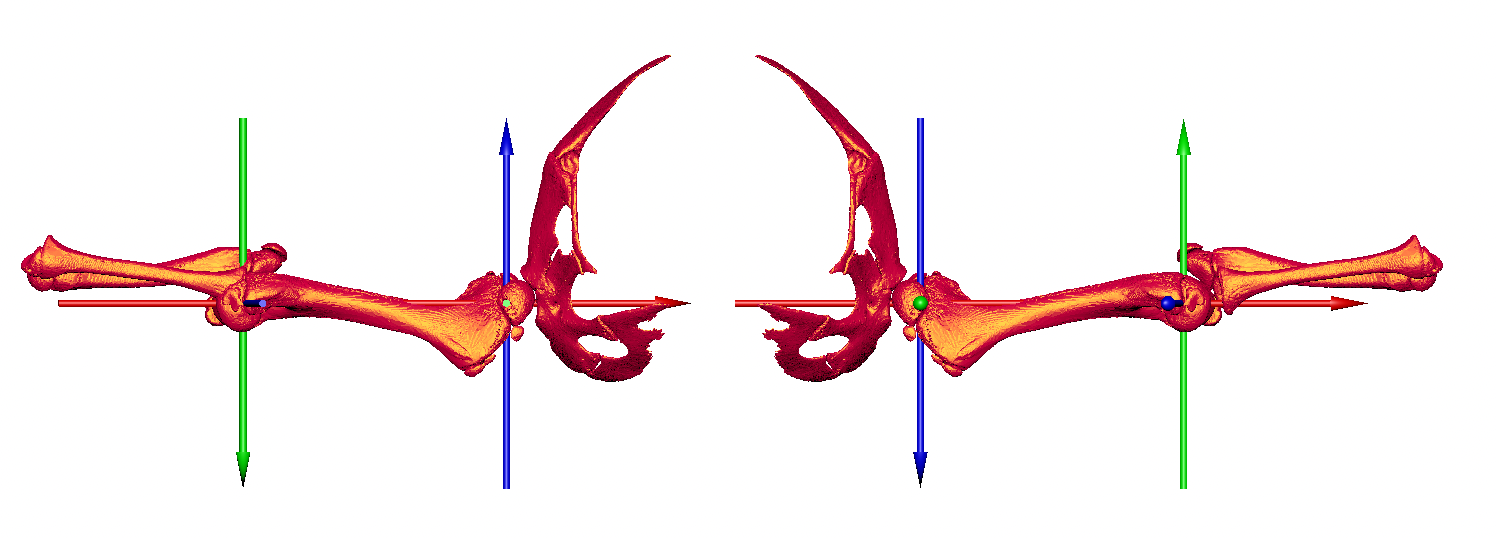
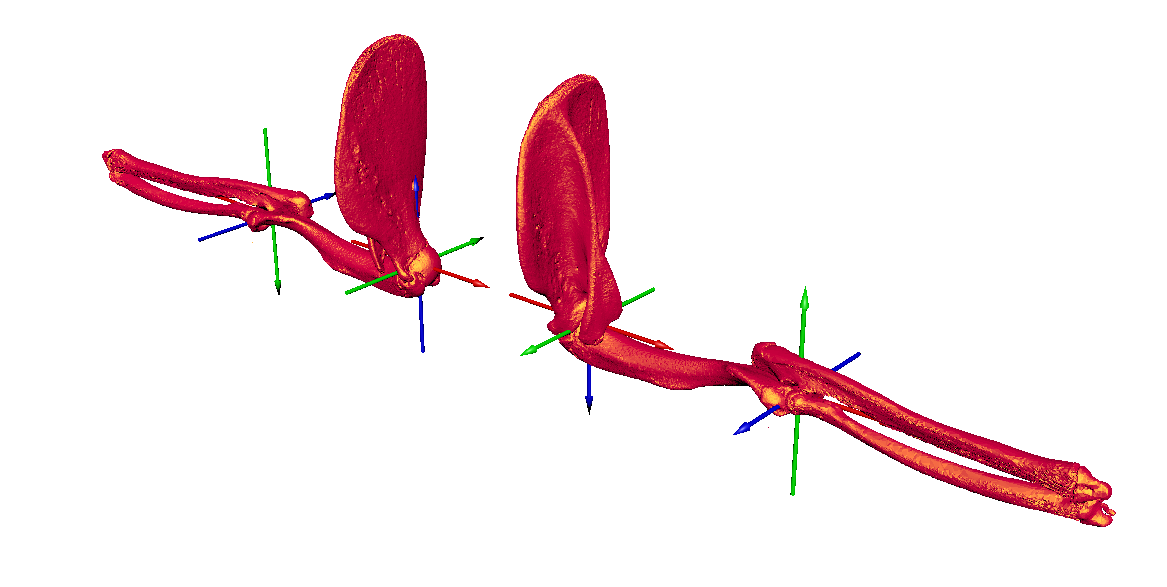

### Misc. params

In [15]:
line_dict = {'tegu_lo':'solid', 'tegu_hi':'dotted', 'opossum_lo':'solid', 'opossum_hi':'dotted'}

### Function declarations

In [281]:
def cropToStance(df, footdown_frame, toeoff_frame, first_good_frame=None, last_good_frame=None):
    result = df.copy()
    mask = [col for col in result.columns if col not in ['frame','stance.percentage']]
    range_target = toeoff_frame-footdown_frame
    df_min = result['frame'].min()
    df_max = result['frame'].max()
    if df_min > footdown_frame:
        prepends = pd.DataFrame(np.nan, index=range(0,df_min-footdown_frame), columns=result.columns)
        prepends['frame'] = range(footdown_frame, df_min)
        result = pd.concat([prepends,result], ignore_index=True)
    if df_max < toeoff_frame:
        postpends = pd.DataFrame(np.nan, index=range(0,toeoff_frame-df_max), columns=result.columns)
        postpends['frame'] = range(df_max+1, toeoff_frame+1) 
        result = pd.concat([result,postpends], ignore_index=True)
    result['stance.percentage'] = (result['frame']-footdown_frame)/range_target*100 
    if first_good_frame:
        if first_good_frame>df_min:
            result.loc[result['frame']<first_good_frame,mask] = np.nan
    if last_good_frame:
        if last_good_frame<df_max:
            result.loc[result['frame']>last_good_frame,mask] = np.nan
    result_0to100 = result.loc[(result['stance.percentage'] >= 0)&(result['stance.percentage'] <= 100)].dropna()
     
    return result_0to100

def resampleByPercent(df):
    df = df.copy()
    onepercent_interval_us = math.ceil((df['dt_stance_s'].max()/df['stance.percentage'].max()).delta)
    hundredthpercent_interval_us = math.ceil(onepercent_interval_us/100)
    df_resample = df.resample(str(hundredthpercent_interval_us)+'N', on='dt_stance_s').mean()
    df_interpol = df_resample.interpolate()
    percent_range = range(math.floor(df_interpol['stance.percentage'].min()), math.ceil(df_interpol['stance.percentage'].max()))
    newdf = pd.DataFrame(columns=df.columns)
    for percent in percent_range:
        percent_row = df_interpol.loc[df_interpol['stance.percentage'].sub(percent).abs().idxmin()]
        percent_row['stance.percentage'] = round(percent_row['stance.percentage'])
        newdf = newdf.append(percent_row, ignore_index=True)
    newdf['stance.percentage'] = newdf['stance.percentage'].astype('int')
    newdf = newdf.set_index('stance.percentage')
    newdf = newdf[~newdf.index.duplicated(keep='first')]
    return newdf

def make4Stack(gs, fig, i,title=''):
        fDict = {'fontsize':8}
        gsn = gs[i].subgridspec(4,1, hspace=0.25)
        gax0 = fig.add_subplot(gsn[0,0])
        gax1 = fig.add_subplot(gsn[1,0])
        gax2 = fig.add_subplot(gsn[2,0])
        gax3 = fig.add_subplot(gsn[3,0])
        for ax, i in zip([gax0, gax1, gax2, gax3],range(1,5)):
            ax.set_title(title+' '+str(i) if title else '', fontdict=fDict)
            ax.tick_params(labelsize=5)
        return [gsn, gax0, gax1, gax2, gax3]

def make4Box(gs, fig, i,title=''):
    fDict = {'fontsize':8}
    gsn = gs[i].subgridspec(2,2, hspace=0.25)
    gax0 = fig.add_subplot(gsn[0,0])
    gax1 = fig.add_subplot(gsn[0,1])
    gax2 = fig.add_subplot(gsn[1,0])
    gax3 = fig.add_subplot(gsn[1,1])
    for ax, i in zip([gax0, gax1, gax2, gax3],range(1,5)):
        ax.set_title(title+' '+str(i) if title else '', fontdict=fDict)
        ax.tick_params(labelsize=7)
        ax.set_xticks([0,25,50,75,100])
    return [gsn, gax0, gax1, gax2, gax3]

    
def make16plot(title, mixed_yScale=False):
    fig = plt.figure(figsize=[12,10])
    gs0 = gridspec.GridSpec(1, 4, figure=fig)
    gs00, tegu_lo_ax1, tegu_lo_ax2, tegu_lo_ax3, tegu_lo_ax4 = make4Stack(gs0, fig, 0, 'Tegu Lo')
    gs01, tegu_hi_ax1, tegu_hi_ax2, tegu_hi_ax3, tegu_hi_ax4 = make4Stack(gs0, fig, 1, 'Tegu Hi')
    gs02, possum_lo_ax1, possum_lo_ax2, possum_lo_ax3, possum_lo_ax4 = make4Stack(gs0, fig, 2, 'Opossum Lo')
    gs03, possum_hi_ax1, possum_hi_ax2, possum_hi_ax3, possum_hi_ax4 = make4Stack(gs0, fig, 3, 'Opossum Hi')
    axes_dict = {   'tegu_lo':[tegu_lo_ax1,tegu_lo_ax2,tegu_lo_ax3,tegu_lo_ax4],
                    'tegu_hi':[tegu_hi_ax1,tegu_hi_ax2,tegu_hi_ax3,tegu_hi_ax4],
                    'opossum_lo':[possum_lo_ax1,possum_lo_ax2,possum_lo_ax3,possum_lo_ax4],
                    'opossum_hi':[possum_hi_ax1,possum_hi_ax2,possum_hi_ax3,possum_hi_ax4]}
    if mixed_yScale:
        twin_dict = axes_dict.copy()
        for condition in twin_dict:
            new_axes = []
            for animal in twin_dict[condition]:
                new = animal.twinx()
                new.tick_params(labelsize=5)
                new_axes.append(new)
            twin_dict[condition] = new_axes
    plt.suptitle(title)
    plt.show()
    return axes_dict if not mixed_yScale else [axes_dict, twin_dict]


def make8plot(title, mixed_yScale=False):
    fig = plt.figure(figsize=[12,10])
    gs0 = gridspec.GridSpec(1, 2, figure=fig)
    gs00, tegu_ax1, tegu_ax2, tegu_ax3, tegu_ax4 = make4Stack(gs0, fig, 0, 'Tegu')
    gs01, opossum_ax1, opossum_ax2, opossum_ax3, opossum_ax4 = make4Stack(gs0, fig, 1, 'Opossum')
    axes_dict = {   'tegu':[tegu_ax1,tegu_ax2,tegu_ax3,tegu_ax4],
                    'opossum':[opossum_ax1,opossum_ax2,opossum_ax3,opossum_ax4]}
    if mixed_yScale:
        twin_dict = axes_dict.copy()
        for condition in twin_dict:
            new_axes = []
            for animal in twin_dict[condition]:
                new = animal.twinx()
                new.tick_params(labelsize=5)
                new_axes.append(new)
            twin_dict[condition] = new_axes
    plt.suptitle(title)
    plt.show()
    return axes_dict if not mixed_yScale else [axes_dict, twin_dict]

def make8plotwith8box(title, mixed_yScale=False):
    fig = plt.figure(figsize=[12,10])
    gs0 = gridspec.GridSpec(2, 2, figure=fig)
    gs00, tegu_ax1, tegu_ax2, tegu_ax3, tegu_ax4 = make4Stack(gs0, fig, 0, 'Tegu')
    gs01, tegu_box1, tegu_box2, tegu_box3, tegu_box4 = make4Stack(gs0, fig, 1)
    gs02, opossum_ax1, opossum_ax2, opossum_ax3, opossum_ax4 = make4Stack(gs0, fig, 2, 'Opossum')
    gs03, opossum_box1, opossum_box2, opossum_box3, opossum_box4 = make4Stack(gs0, fig, 3)
    axes_dict = {   'tegu':[tegu_ax1,tegu_ax2,tegu_ax3,tegu_ax4],
                    'tegu_box':[tegu_box1, tegu_box2, tegu_box3, tegu_box4],
                    'opossum':[opossum_ax1,opossum_ax2,opossum_ax3,opossum_ax4],
                    'opossum_box':[opossum_box1, opossum_box2, opossum_box3, opossum_box4]}
    if mixed_yScale:
        twin_dict = axes_dict.copy()
        for condition in twin_dict:
            new_axes = []
            for animal in twin_dict[condition]:
                new = animal.twinx()
                new.tick_params(labelsize=5)
                new_axes.append(new)
            twin_dict[condition] = new_axes
    plt.suptitle(title)
    plt.show()
    return axes_dict if not mixed_yScale else [axes_dict, twin_dict]

def makeDeltaLayout(title, mixed_yScale=False, hide_duplicate_axes=False):
    fig = plt.figure(figsize=[12,12])
    gs0 = gridspec.GridSpec(2, 2, figure=fig)
    gs00, tegu_ax1, tegu_ax2, tegu_ax3, tegu_ax4 = make4Box(gs0, fig, 0, 'Tegu')
    gs01, opossum_ax1, opossum_ax2, opossum_ax3, opossum_ax4 = make4Box(gs0, fig, 1, 'Opossum')
    tegu_box = fig.add_subplot(gs0[1,0])
    opossum_box = fig.add_subplot(gs0[1,1], sharey=tegu_box)
    axes_dict = {   'tegu':[tegu_ax1,tegu_ax2,tegu_ax3,tegu_ax4],
                    'opossum':[opossum_ax1,opossum_ax2,opossum_ax3,opossum_ax4],
                    'tegu_box':[tegu_box],
                    'opossum_box':[opossum_box]}
    if mixed_yScale:
        twin_dict = axes_dict.copy()
        for condition in twin_dict:
            new_axes = []
            for animal in twin_dict[condition]:
                new = animal.twinx()
                new.tick_params(labelsize=5)
                new_axes.append(new)
            twin_dict[condition] = new_axes
    plt.suptitle(title)
    return axes_dict if not mixed_yScale else [axes_dict, twin_dict]

def plotDeltas(title, var_specs, col_filter, secondary_col_filter=None):
    maxRot = all_raw.filter(regex=col_filter).max().max()
    minRot = all_raw.filter(regex=col_filter).min().min()
    rotRange = abs(maxRot-minRot)
    maxRot = maxRot + rotRange * 0.25
    minRot = minRot - rotRange * 0.25
    if secondary_col_filter:
        deltas, secondary = makeDeltaLayout(title, mixed_yScale=True)
        maxLen = all_raw.filter(regex=secondary_col_filter).max().max()
        minLen = all_raw.filter(regex=secondary_col_filter).min().min()
        lenRange = abs(maxLen-minLen)
        maxLen = maxLen + lenRange * 0.25
        minLen = minLen - lenRange * 0.25
    else: 
        deltas = makeDeltaLayout(title)
    for species in ['tegu','opossum']:
        all_intersect_index = set(range(0,101))
        for i in range(0,4):
            intersect_index = set(list(raw_dict[species+'_lo'][i].index)).intersection(set(list(raw_dict[species+'_hi'][i].index)))
            all_intersect_index = all_intersect_index.intersection(intersect_index)
            for manip in ['lo','hi']:
                condition = species+'_'+manip
                df_to_plot = raw_dict[condition][i].loc[intersect_index]
                for var in var_specs:
                    deltas[species][i].plot(df_to_plot[var['var']], c=var['color'], linestyle=line_dict[condition])
            for var in [var for var in var_specs if re.match(col_filter,var['var'])]:
                var_name, var_color = var['var'],var['color']
                deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,var_name], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,var_name], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,var_name]<raw_dict[species+'_hi'][i].loc[intersect_index,var_name],
                                                color=var_color, alpha=0.75, hatch='||||||||||', facecolor='white' )
                deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,var_name], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,var_name], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,var_name]>=raw_dict[species+'_hi'][i].loc[intersect_index,var_name],
                                                color=var_color, alpha=0.75, hatch='-----', facecolor='white' )
            if secondary_col_filter:
                for var in [var for var in var_specs if re.match(secondary_col_filter,var['var'])]:
                    var_name, var_color = var['var'],var['color']
                    secondary[species][i].fill_between(list(intersect_index), 
                                                    raw_dict[species+'_lo'][i].loc[intersect_index,var_name], 
                                                    raw_dict[species+'_hi'][i].loc[intersect_index,var_name], 
                                                    where= raw_dict[species+'_lo'][i].loc[intersect_index,var_name]<raw_dict[species+'_hi'][i].loc[intersect_index,var_name],
                                                    color=var_color, alpha=0.75, hatch='||||||||||', facecolor='white' )
                    secondary[species][i].fill_between(list(intersect_index), 
                                                    raw_dict[species+'_lo'][i].loc[intersect_index,var_name], 
                                                    raw_dict[species+'_hi'][i].loc[intersect_index,var_name], 
                                                    where= raw_dict[species+'_lo'][i].loc[intersect_index,var_name]>=raw_dict[species+'_hi'][i].loc[intersect_index,var_name],
                                                    color=var_color, alpha=0.75, hatch='-----', facecolor='white' )
                secondary[species][i].set_ylim(minLen, maxLen)
            deltas[species][i].set_ylim(minRot, maxRot)
            deltas[species][i].set_xlim(0, 100)
            deltas[species][i].axhline(y=0, c='black', linewidth=0.5, linestyle='dotted')
        box_df = all_raw.loc[all_raw['species']==species.capitalize()].loc[all_intersect_index].set_index('uid').filter(regex=col_filter+'|condition').sort_values(by='condition', ascending=False).melt(id_vars=['condition'])
        species_box = sns.violinplot(x='variable', y='value', hue='condition', ax=deltas[species+'_box'][0], data=box_df, linewidth=2)
        species_box.set_ylim(minRot, maxRot)
        sns.despine(left=True, bottom=True)
        species_box.legend([],[], frameon=False)
        print(species_box.get_children())
        for i,j in zip([var['color'] for var in var_specs],[[0,2],[4,6],[8,10]]):
            for k in j:
                species_box.get_children()[k].set_color(i)
                species_box.get_children()[k].set_alpha(0.75)
#                 species_box.get_children()[k].set_hatch('||||||||||' if k in [2,6,10] else '-----')
#                 species_box.get_children()[k].set_facecolor('white')
        species_box, test_results = add_stat_annotation(species_box, data=box_df, x='variable', y='value', hue='condition',
                                                        box_pairs=[((var_specs[0]['var'],'lo'),(var_specs[0]['var'],'hi')),
                                                                   ((var_specs[1]['var'],'lo'),(var_specs[1]['var'],'hi')),
                                                                   ((var_specs[2]['var'],'lo'),(var_specs[2]['var'],'hi'))], test='t-test_ind', verbose=0
                                                                    )
        species_box.axhline(y=0, c='black', linewidth=0.5, linestyle='dotted')
        species_box.set_title(species.capitalize()+' lo vs hi')
        for label in species_box.get_xticklabels()+species_box.get_xticklines()+species_box.get_yticklabels()+species_box.get_yticklines():
            label.set_visible(False)
        species_box.xaxis.set_label_text('')
        species_box.yaxis.set_label_text('')
    plt.show()
    return(deltas)

In [206]:
all_raw.filter(regex='elbow.rotate').max()


elbow.rotateX     10.744681
elbow.rotateY      6.606564
elbow.rotateZ    145.226016
dtype: float64

In [208]:
all_raw.filter(regex='elbow.rotate').max().max()


145.226016067624

In [207]:
all_raw.filter(regex='elbow.rotate').min().min()


-18.983735500885174

In [205]:
all_raw.filter(regex='elbow.rotate').min()


elbow.rotateX    -2.120781
elbow.rotateY   -18.983736
elbow.rotateZ    39.262155
dtype: float64

## Data
### Import

In [296]:
raw_dfs = {}
raw_dfs['feb3_13_t2'] = pd.read_csv('/Users/phil/Desktop/rotoscoping/Feb3_Lai/13_t2_stand_IK_baked_data_animalFrame.csv', 
                     index_col=None)
raw_dfs['feb3_12_t2'] = pd.read_csv('/Users/phil/Desktop/rotoscoping/Feb3_Lai/12_t2_stand_IK_baked_data_animalFrame.csv', 
                     index_col=None)
raw_dfs['feb3_11_t1'] = pd.read_csv('/Users/phil/Desktop/rotoscoping/Feb3_Lai/11_t1_stand_IK_baked_data_animalFrame.csv', 
                     index_col=None)
raw_dfs['feb3_3_p1'] = pd.read_csv('/Users/phil/Desktop/rotoscoping/Feb3_Lai/3_p1_stand_IK_baked_data_animalFrame.csv', 
                     index_col=None)
raw_dfs['feb3_2_p3'] = pd.read_csv('/Users/phil/Desktop/rotoscoping/Feb3_Lai/2_p3_stand_IK_baked_data_animalFrame.csv', 
                     index_col=None)
raw_dfs['nov1_5_t1'] = pd.read_csv('/Users/phil/Desktop/rotoscoping/Nov1_LaiWright/5_t1_squeeze_A+_IK_baked_data_animalFrame.csv', 
                     index_col=None)
raw_dfs['nov1_6_t4'] = pd.read_csv('/Users/phil/Desktop/rotoscoping/Nov1_LaiWright/6_t4_squeeze_A-_IK_baked_data_animalFrame.csv', 
                     index_col=None)
raw_dfs['nov6_12_p1'] = pd.read_csv('/Users/phil/Desktop/rotoscoping/Nov6_LaiBiewener/12_p1_squeezelow_A_IK_baked_data_animalFrame.csv', 
                     index_col=None)
raw_dfs['nov6_9_p3'] = pd.read_csv('/Users/phil/Desktop/rotoscoping/Nov6_LaiBiewener/9_p3_squeezelow_A_IK_baked_data_animalFrame.csv', 
                     index_col=None)
raw_dfs['nov6_3_p4'] = pd.read_csv('/Users/phil/Desktop/rotoscoping/Nov6_LaiBiewener/3_p4_squeezelow_A_IK_baked_data_animalFrame.csv', 
                     index_col=None)
raw_dfs['oct7_21_t2'] = pd.read_csv('/Users/phil/Desktop/rotoscoping/Oct7_LaiWright/21_t2_fullstride_A_IK_baked_data_animalFrame.csv', 
                     index_col=None)
raw_dfs['oct7_9_t4'] = pd.read_csv('/Users/phil/Desktop/rotoscoping/Oct7_LaiWright/9_t4_fullstride_A_IK_baked_data_animalFrame.csv', 
                     index_col=None)
raw_dfs['oct7_23_t3'] = pd.read_csv('/Users/phil/Desktop/rotoscoping/Oct7_LaiWright/23_t3_fullstride_A_IK_baked_data_animalFrame.csv', 
                     index_col=None)
raw_dfs['oct7_12_t1'] = pd.read_csv('/Users/phil/Desktop/rotoscoping/Oct7_LaiWright/12_t1_fullstride_A_IK_baked_data_animalFrame.csv', 
                     index_col=None)
raw_dfs['oct7_20_t3'] = pd.read_csv('/Users/phil/Desktop/rotoscoping/Oct7_LaiWright/20_t3_fullstride_A_IK_baked_data_animalFrame.csv', 
                     index_col=None)
raw_dfs['oct9_14_p1'] = pd.read_csv('/Users/phil/Desktop/rotoscoping/Oct9_LaiPierceBiewener/14_p1_fullstride_A-_IK_baked_data_animalFrame.csv', 
                     index_col=None)
raw_dfs['oct9_9_p3'] = pd.read_csv('/Users/phil/Desktop/rotoscoping/Oct9_LaiPierceBiewener/9_p3_fullstride_A-_IK_baked_data_animalFrame.csv', 
                     index_col=None)
raw_dfs['oct14_3_p2'] = pd.read_csv('/Users/phil/Desktop/rotoscoping/Oct14_LaiBiewener/3_p2_fullstride_IK_baked_data_animalFrame.csv', 
                     index_col=None)
raw_dfs['oct14_8_p4'] = pd.read_csv('/Users/phil/Desktop/rotoscoping/Oct14_LaiBiewener/8_p4_fullstride_a_IK_baked_data_animalFrame.csv', 
                     index_col=None)
raw_dfs['oct16_9_p2'] = pd.read_csv('/Users/phil/Desktop/rotoscoping/Oct16_LaiWright/9_p2_squeeze_A+_IK_baked_data_animalFrame.csv', 
                     index_col=None)
raw_dfs['oct23_2_t2'] = pd.read_csv('/Users/phil/Desktop/rotoscoping/Oct23_LaiWright/2_t2_squeeze_A-_IK_baked_data_animalFrame.csv', 
                     index_col=None)
raw_list = ['feb3_13_t2', 'feb3_12_t2', 'feb3_11_t1', 'feb3_3_p1', 'feb3_2_p3', 'nov1_5_t1', 
           'nov1_6_t4', 'nov6_12_p1', 'nov6_9_p3', 'nov6_3_p4', 'oct7_21_t2', 'oct7_9_t4', 
           'oct7_23_t3', 'oct7_12_t1', 'oct7_20_t3', 'oct9_14_p1', 'oct9_9_p3', 'oct14_3_p2', 
           'oct14_8_p4', 'oct16_9_p2', 'oct23_2_t2']

tegu_lo = ['oct7_12_t1','oct7_21_t2','oct7_23_t3','oct7_9_t4']
tegu_hi = ['nov1_5_t1','oct23_2_t2','oct7_20_t3','nov1_6_t4']
opossum_lo = ['nov6_12_p1','oct16_9_p2','nov6_9_p3','nov6_3_p4']
opossum_hi = ['oct9_14_p1','oct14_3_p2','oct9_9_p3','oct14_8_p4']
walking_names = tegu_lo + tegu_hi + opossum_lo + opossum_hi
lo_names = tegu_lo + opossum_lo
hi_names = tegu_hi + opossum_hi

SEP73_rhum_len_mm = 42.745
SEP87_rhum_len_mm = 66.851

metadata = {
    'oct7_12_t1':{'footdown_frame':260, 'toeoff_frame':591, 'first_good_frame':None,'last_good_frame':None, 'hum_length':SEP73_rhum_len_mm*1.073},
    'oct7_21_t2':{'footdown_frame':281, 'toeoff_frame':534, 'first_good_frame':None,'last_good_frame':None, 'hum_length':SEP73_rhum_len_mm*1.057},
    'oct7_23_t3':{'footdown_frame':206, 'toeoff_frame':590, 'first_good_frame':None,'last_good_frame':None, 'hum_length':SEP73_rhum_len_mm*1.050},
    'oct7_9_t4':{'footdown_frame':238, 'toeoff_frame':601, 'first_good_frame':None,'last_good_frame':None, 'hum_length':SEP73_rhum_len_mm*0.953},
    'nov1_5_t1':{'footdown_frame':294, 'toeoff_frame':561, 'first_good_frame':None,'last_good_frame':None, 'hum_length':SEP73_rhum_len_mm*1.073},
    'oct23_2_t2':{'footdown_frame':312, 'toeoff_frame':617, 'first_good_frame':None,'last_good_frame':None, 'hum_length':SEP73_rhum_len_mm*1.057},
    'oct7_20_t3':{'footdown_frame':215, 'toeoff_frame':529, 'first_good_frame':None,'last_good_frame':None, 'hum_length':SEP73_rhum_len_mm*1.050},
    'nov1_6_t4':{'footdown_frame':277, 'toeoff_frame':583, 'first_good_frame':None,'last_good_frame':None, 'hum_length':SEP73_rhum_len_mm*0.953},
    'nov6_12_p1':{'footdown_frame':267, 'toeoff_frame':324, 'first_good_frame':None,'last_good_frame':None, 'hum_length':SEP87_rhum_len_mm*0.777},
    'oct16_9_p2':{'footdown_frame':71, 'toeoff_frame':159, 'first_good_frame':None,'last_good_frame':None, 'hum_length':SEP87_rhum_len_mm*0.791},
    'nov6_9_p3':{'footdown_frame':295, 'toeoff_frame':430, 'first_good_frame':None,'last_good_frame':None, 'hum_length':SEP87_rhum_len_mm*0.795},
    'nov6_3_p4':{'footdown_frame':170, 'toeoff_frame':315, 'first_good_frame':None,'last_good_frame':None, 'hum_length':SEP87_rhum_len_mm*0.746},
    'oct9_14_p1':{'footdown_frame':130, 'toeoff_frame':258, 'first_good_frame':None,'last_good_frame':None, 'hum_length':SEP87_rhum_len_mm*0.735},
    'oct14_3_p2':{'footdown_frame':172, 'toeoff_frame':254, 'first_good_frame':None,'last_good_frame':None, 'hum_length':SEP87_rhum_len_mm*0.791},
    'oct9_9_p3':{'footdown_frame':178, 'toeoff_frame':342, 'first_good_frame':None,'last_good_frame':None, 'hum_length':SEP87_rhum_len_mm*0.793},
    'oct14_8_p4':{'footdown_frame':378, 'toeoff_frame':488, 'first_good_frame':None,'last_good_frame':None, 'hum_length':SEP87_rhum_len_mm*0.773},
    'feb3_2_p3':{'footdown_frame':301, 'toeoff_frame':302, 'first_good_frame':None,'last_good_frame':None, 'hum_length':SEP87_rhum_len_mm*0.824},
    'feb3_3_p1':{'footdown_frame':700, 'toeoff_frame':701, 'first_good_frame':None,'last_good_frame':None, 'hum_length':SEP87_rhum_len_mm*0.820},
    'feb3_11_t1':{'footdown_frame':580, 'toeoff_frame':581, 'first_good_frame':None,'last_good_frame':None, 'hum_length':SEP87_rhum_len_mm*1.073},
    'feb3_12_t2':{'footdown_frame':60, 'toeoff_frame':61, 'first_good_frame':None,'last_good_frame':None, 'hum_length':SEP87_rhum_len_mm*1.057},
    'feb3_13_t2':{'footdown_frame':200, 'toeoff_frame':201, 'first_good_frame':None,'last_good_frame':None, 'hum_length':SEP87_rhum_len_mm*1.057}
}



for raw_df in raw_dfs:
    ## calculate rate vars
    raw_dfs[raw_df]['time_s'] = raw_dfs[raw_df]['frame']/60
    raw_dfs[raw_df]['dt_elapsed_s'] = (pd.to_datetime(raw_dfs[raw_df]['time_s'],unit='s')-datetime(1970, 1, 1))
    
    raw_dfs[raw_df]['travel_velocity_X'] = np.diff(raw_dfs[raw_df]['animal.translateX'], prepend=np.nan)/np.diff(raw_dfs[raw_df]['time_s'], prepend=np.nan)
    raw_dfs[raw_df]['glenoid.angular_v_X'] = np.diff(raw_dfs[raw_df]['glenoid.rotateX'], prepend=np.nan)/np.diff(raw_dfs[raw_df]['time_s'], prepend=np.nan)
    raw_dfs[raw_df]['glenoid.angular_v_Y'] = np.diff(raw_dfs[raw_df]['glenoid.rotateY'], prepend=np.nan)/np.diff(raw_dfs[raw_df]['time_s'], prepend=np.nan)
    raw_dfs[raw_df]['glenoid.angular_v_Z'] = np.diff(raw_dfs[raw_df]['glenoid.rotateZ'], prepend=np.nan)/np.diff(raw_dfs[raw_df]['time_s'], prepend=np.nan)
    raw_dfs[raw_df]['elbow.angular_v_X'] = np.diff(raw_dfs[raw_df]['elbow.rotateX'], prepend=np.nan)/np.diff(raw_dfs[raw_df]['time_s'], prepend=np.nan)
    raw_dfs[raw_df]['elbow.angular_v_Y'] = np.diff(raw_dfs[raw_df]['elbow.rotateY'], prepend=np.nan)/np.diff(raw_dfs[raw_df]['time_s'], prepend=np.nan)
    raw_dfs[raw_df]['elbow.angular_v_Z'] = np.diff(raw_dfs[raw_df]['elbow.rotateZ'], prepend=np.nan)/np.diff(raw_dfs[raw_df]['time_s'], prepend=np.nan)
    raw_dfs[raw_df]['glenoid.power_X'] = raw_dfs[raw_df]['glenoid.angular_v_X']*raw_dfs[raw_df]['glenoidTorque.XaxisTorque']
    raw_dfs[raw_df]['glenoid.power_Y'] = raw_dfs[raw_df]['glenoid.angular_v_Y']*raw_dfs[raw_df]['glenoidTorque.YaxisTorque']
    raw_dfs[raw_df]['glenoid.power_Z'] = raw_dfs[raw_df]['glenoid.angular_v_Z']*raw_dfs[raw_df]['glenoidTorque.ZaxisTorque']
    raw_dfs[raw_df]['elbow.power_X'] = raw_dfs[raw_df]['elbow.angular_v_X']*raw_dfs[raw_df]['elbowTorque.XaxisTorque']
    raw_dfs[raw_df]['elbow.power_Y'] = raw_dfs[raw_df]['elbow.angular_v_Y']*raw_dfs[raw_df]['elbowTorque.YaxisTorque']
    raw_dfs[raw_df]['elbow.power_Z'] = raw_dfs[raw_df]['elbow.angular_v_Z']*raw_dfs[raw_df]['elbowTorque.ZaxisTorque']
    raw_dfs[raw_df]['glenoid.power'] = raw_dfs[raw_df]['glenoid.power_X']+raw_dfs[raw_df]['glenoid.power_Y']+raw_dfs[raw_df]['glenoid.power_Z']
    raw_dfs[raw_df]['elbow.power'] = raw_dfs[raw_df]['elbow.power_X']+raw_dfs[raw_df]['elbow.power_Y']+raw_dfs[raw_df]['elbow.power_Z']
    ## normalize distances to humeral length (IGD is variable!)
    for distance in ['animal.shoulderHeight','animal.localShoulderPosX',
       'animal.localShoulderPosY', 'animal.localShoulderPosZ',
       'animal.localElbowPosX', 'animal.localElbowPosY',
       'animal.localElbowPosZ', 'animal.localWristPosX',
       'animal.localWristPosY', 'animal.localWristPosZ']:
        raw_dfs[raw_df][distance] /= (metadata[raw_df]['hum_length'])
    raw_dfs[raw_df]['animal.shoulderWidth'] = raw_dfs[raw_df]['animal.localShoulderPosY']*-1
    raw_dfs[raw_df]['animal.elbowWidth'] = raw_dfs[raw_df]['animal.localElbowPosY']*-1
    raw_dfs[raw_df]['animal.wristWidth'] = raw_dfs[raw_df]['animal.localWristPosY']*-1
    ## trim to stance:
    raw_dfs[raw_df] = cropToStance(raw_dfs[raw_df], metadata[raw_df]['footdown_frame'], metadata[raw_df]['toeoff_frame'], metadata[raw_df]['first_good_frame'], metadata[raw_df]['last_good_frame'])
    raw_dfs[raw_df]['dt_stance_s'] = raw_dfs[raw_df]['dt_elapsed_s'] - raw_dfs[raw_df]['dt_elapsed_s'].min()
    ## resample by stance percentage:
    if raw_df in walking_names:
        raw_dfs[raw_df] = resampleByPercent(raw_dfs[raw_df])
    ## add metadata
    raw_dfs[raw_df]['uid'] = raw_df+'_'+raw_dfs[raw_df].index.astype(str)
    raw_dfs[raw_df]['individual_id'] = raw_df.rsplit('_',1)[1]
    raw_dfs[raw_df].loc[raw_dfs[raw_df]['individual_id'].str.contains('p'),'species'] = 'Opossum'
    raw_dfs[raw_df].loc[raw_dfs[raw_df]['individual_id'].str.contains('t'),'species'] = 'Tegu'
    raw_dfs[raw_df]['individual'] = raw_dfs[raw_df]['species'] + ' ' + raw_dfs[raw_df]['individual_id'].str[1:]
    raw_dfs[raw_df]['condition'] = 'lo' if raw_df in lo_names else 'hi'
    raw_dfs[raw_df]['meta.spineBendRange'] = abs(raw_dfs[raw_df]['animal.spineBend'].max() - raw_dfs[raw_df]['animal.spineBend'].min())
    raw_dfs[raw_df]['meta.shoulderLARRange'] = abs(raw_dfs[raw_df]['glenoid.rotateX'].max() - raw_dfs[raw_df]['glenoid.rotateX'].min())
    midstanceRow = raw_dfs[raw_df].loc[50] if 50 in raw_dfs[raw_df].index else raw_dfs[raw_df].loc[1]
    raw_dfs[raw_df]['meta.midstanceHeight'] = midstanceRow['animal.shoulderHeight']
    ## calculate parasagittality
    elbow_pos = np.array(raw_dfs[raw_df].filter(like='animal.localShoulderPos'))
    glenoid_pos = np.array(raw_dfs[raw_df].filter(like='animal.localElbowPos'))
    wrist_pos = np.array(raw_dfs[raw_df].filter(like='animal.localWristPos'))
    vecA = elbow_pos - glenoid_pos
    vecB = wrist_pos - glenoid_pos
    limb_plane_normal = np.cross(vecA, vecB)
    limb_plane_normal_unit = limb_plane_normal/np.linalg.norm(limb_plane_normal, axis=1)[:,None]
    raw_dfs[raw_df]['parasagittalityX'] = np.einsum('ij,ij->i', np.repeat([[1,0,0]],len(limb_plane_normal), axis=0), limb_plane_normal_unit)
    raw_dfs[raw_df]['parasagittalityY'] = np.einsum('ij,ij->i', np.repeat([[0,1,0]],len(limb_plane_normal), axis=0), limb_plane_normal_unit)
    raw_dfs[raw_df]['parasagittalityZ'] = np.einsum('ij,ij->i', np.repeat([[0,0,1]],len(limb_plane_normal), axis=0), limb_plane_normal_unit)*-1
    
raw_dict = {'tegu_lo':[raw_dfs[trial] for trial in tegu_lo],
            'tegu_hi':[raw_dfs[trial] for trial in tegu_hi],
            'opossum_lo':[raw_dfs[trial] for trial in opossum_lo],
            'opossum_hi':[raw_dfs[trial] for trial in opossum_hi]}
walking_list = [raw_dfs[trial] for trial in raw_list if 'feb3' not in trial]
standing_list = [raw_dfs[trial] for trial in raw_list if 'feb3' in trial]
all_raw = pd.concat(walking_list)
all_raw_with_stand = pd.concat(raw_dfs)
all_stand = pd.concat(standing_list)



### Export for Rob's models

In [5]:
rob_df = all_raw_with_stand[['uid','species','acromion.translateX',
       'acromion.translateY', 'acromion.translateZ', 'acromion.rotateX',
       'acromion.rotateY', 'acromion.rotateZ', 'glenoid.translateX',
       'glenoid.translateY', 'glenoid.translateZ', 'glenoid.rotateX',
       'glenoid.rotateY', 'glenoid.rotateZ', 'elbow.translateX',
       'elbow.translateY', 'elbow.translateZ', 'elbow.rotateX',
       'elbow.rotateY', 'elbow.rotateZ']].set_index(['uid'])
rob_df.to_csv('/Users/phil/Downloads/in_vivo_rob.csv')

In [7]:

smoothed_data = all_raw.copy()

sampling_f = 60
cutoff = 2/(800/60)*10  #10x frequency of motion per xromm guidelines
def make_butter(data, cutoff, sampling_f):
    b, a = signal.butter(4, cutoff, btype='lowpass', fs=sampling_f)
    y = signal.filtfilt(b, a, data)
    return y

# for trial_id in csv_dict.keys():
#     sampling_f = log.loc[trial_id,'ATI sampling (Hz)']
#     filt_norm_force_df.loc[trial_id,'FX_sum'] = make_butter(filt_norm_force_df.loc[trial_id,'FX_sum'], opt_cutoff, sampling_f)
#     filt_norm_force_df.loc[trial_id,'FY_sum'] = make_butter(filt_norm_force_df.loc[trial_id,'FY_sum'], opt_cutoff, sampling_f)
#     filt_norm_force_df.loc[trial_id,'FZ_sum'] = make_butter(filt_norm_force_df.loc[trial_id,'FZ_sum'], opt_cutoff, sampling_f)
#     ezplot(filt_norm_force_df.loc[trial_id])

### Glenoid deltas w/ pooled stats

In [269]:
plt.close('all')
col_filter = 'glenoid.rotate'
title = 'Glenoid deltas'
var_specs = [{'var':'glenoid.rotateX','color':'red'},
            {'var':'glenoid.rotateY','color':'green'},
            {'var':'glenoid.rotateZ','color':'blue'}]
plotDeltas(title, var_specs, col_filter)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Elbow deltas w/ pooled stats

In [270]:
plt.close('all')
col_filter = 'elbow.rotate'
title = 'Elbow deltas'
var_specs = [{'var':'elbow.rotateX','color':'red'},
            {'var':'elbow.rotateY','color':'green'},
            {'var':'elbow.rotateZ','color':'blue'}]
plotDeltas(title, var_specs, col_filter)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Joint widths w/ pooled stats

In [282]:
plt.close('all')
col_filter = 'animal.[a-z]*Width'
title = 'Joint width deltas'
var_specs = [{'var':'animal.shoulderWidth','color':'orange'},
            {'var':'animal.elbowWidth','color':'teal'},
            {'var':'animal.wristWidth','color':'purple'}]
plotDeltas(title, var_specs, col_filter)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[<matplotlib.collections.PolyCollection object at 0x159c54ca0>, <matplotlib.collections.PathCollection object at 0x159c62700>, <matplotlib.collections.PolyCollection object at 0x159c62e20>, <matplotlib.collections.PathCollection object at 0x159c6f520>, <matplotlib.collections.PolyCollection object at 0x159c6fa30>, <matplotlib.collections.PathCollection object at 0x159c7b220>, <matplotlib.collections.PolyCollection object at 0x159c7b730>, <matplotlib.collections.PathCollection object at 0x159c6f5e0>, <matplotlib.collections.PolyCollection object at 0x159c88310>, <matplotlib.collections.PathCollection object at 0x159c88ac0>, <matplotlib.collections.PolyCollection object at 0x159c88fd0>, <matplotlib.collections.PathCollection object at 0x159c977c0>, <matplotlib.patches.Rectangle object at 0x159c54940>, <matplotlib.patches.Rectangle object at 0x159c54f40>, <matplotlib.lines.Line2D object at 0x159c62160>, <matplotlib.lines.Line2D object at 0x159c624c0>, <matplotlib.lines.Line2D object at 0x

### Sprawl params w/ pooled stats

In [ ]:
plt.close('all')
angle_params, length_param = make16plot('Sprawling parameters', mixed_yScale=True)
maxRot = all_raw.filter(regex='animal.spineBend|glenoid.rotateX').max().max()
minRot = all_raw.filter(regex='animal.spineBend|glenoid.rotateX').min().min()
maxLen = all_raw.filter(like='animal.shoulderHeight').max().max()
minLen = all_raw.filter(like='animal.shoulderHeight').min().min()

for condition in raw_dict:
    for i in range(0,4):
        angle_params[condition][i].plot(raw_dict[condition][i]['animal.spineBend'],c='pink')
        angle_params[condition][i].plot(raw_dict[condition][i]['glenoid.rotateX'],c='red')
        length_param[condition][i].plot(raw_dict[condition][i]['animal.shoulderHeight'],c='indigo')
        angle_params[condition][i].set_ylim(minRot, maxRot)
        length_param[condition][i].set_ylim(minLen, maxLen)
        angle_params[condition][i].set_xlim(0, 100)
plt.show()



In [273]:
plt.close('all')

col_filter = 'animal.spineBend|glenoid.rotateX'
secondary_col_filter = 'animal.shoulderHeight'
title = 'Joint width deltas'
var_specs = [{'var':'animal.spineBend','color':'pink'},
            {'var':'glenoid.rotateX','color':'red'},
            {'var':'animal.shoulderHeight','color':'indigo'}]
plotDeltas(title, var_specs, col_filter, secondary_col_filter)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

ValueError: box_pairs contains an invalid box pair.

### Sprawl space

In [289]:
spaceDF = all_raw.loc[50,['meta.spineBendRange','meta.shoulderLARRange','meta.midstanceHeight','species','individual','individual_id','condition']]

plot_x = 'meta.spineBendRange'
plot_y = 'meta.shoulderLARRange'
plot_z = 'meta.midstanceHeight'

hi_df = spaceDF.loc[spaceDF['condition']=='hi']
lo_df = spaceDF.loc[spaceDF['condition']=='lo']

t1_l, t2_l, t3_l, t4_l = lo_df[lo_df['individual_id']=='t1'], lo_df[lo_df['individual_id']=='t2'], lo_df[lo_df['individual_id']=='t3'], lo_df[lo_df['individual_id']=='t4']
t1_h, t2_h, t3_h, t4_h = hi_df[hi_df['individual_id']=='t1'], hi_df[hi_df['individual_id']=='t2'], hi_df[hi_df['individual_id']=='t3'], hi_df[hi_df['individual_id']=='t4']
p1_l, p2_l, p3_l, p4_l = lo_df[lo_df['individual_id']=='p1'], lo_df[lo_df['individual_id']=='p2'], lo_df[lo_df['individual_id']=='p3'], lo_df[lo_df['individual_id']=='p4']
p1_h, p2_h, p3_h, p4_h = hi_df[hi_df['individual_id']=='p1'], hi_df[hi_df['individual_id']=='p2'], hi_df[hi_df['individual_id']=='p3'], hi_df[hi_df['individual_id']=='p4']

tegu_vecs = [[[t1_l.at[50, plot_x],t1_h.at[50, plot_x]],[t1_l.at[50, plot_y],t1_h.at[50, plot_y]],[t1_l.at[50, plot_z],t1_h.at[50, plot_z]]],
                [[t2_l.at[50, plot_x],t2_h.at[50, plot_x]],[t2_l.at[50, plot_y],t2_h.at[50, plot_y]],[t2_l.at[50, plot_z],t2_h.at[50, plot_z]]],
                [[t3_l.at[50, plot_x],t3_h.at[50, plot_x]],[t3_l.at[50, plot_y],t3_h.at[50, plot_y]],[t3_l.at[50, plot_z],t3_h.at[50, plot_z]]],
                [[t4_l.at[50, plot_x],t4_h.at[50, plot_x]],[t4_l.at[50, plot_y],t4_h.at[50, plot_y]],[t4_l.at[50, plot_z],t4_h.at[50, plot_z]]],
               ]
opossum_vecs = [[[p1_l.at[50, plot_x],p1_h.at[50, plot_x]],[p1_l.at[50, plot_y],p1_h.at[50, plot_y]],[p1_l.at[50, plot_z],p1_h.at[50, plot_z]]],
                [[p2_l.at[50, plot_x],p2_h.at[50, plot_x]],[p2_l.at[50, plot_y],p2_h.at[50, plot_y]],[p2_l.at[50, plot_z],p2_h.at[50, plot_z]]],
                [[p3_l.at[50, plot_x],p3_h.at[50, plot_x]],[p3_l.at[50, plot_y],p3_h.at[50, plot_y]],[p3_l.at[50, plot_z],p3_h.at[50, plot_z]]],
                [[p4_l.at[50, plot_x],p4_h.at[50, plot_x]],[p4_l.at[50, plot_y],p4_h.at[50, plot_y]],[p4_l.at[50, plot_z],p4_h.at[50, plot_z]]],
               ]

viewYZ = (0,0)
viewXZ = (0,90)
viewXY = (90,90)
view3Q = (45,45)
view3Qst = (-45,45)
view3Qsw = (135,45)

vX, vY = viewXY

plt.close('all')
plt.rcParams['grid.linewidth'] = 1
plt.rcParams['grid.color'] = 'lightgrey'
plt.rcParams['axes.facecolor'] = 'white'


colors = {'Opossum':'orange', 'Tegu':'teal'}

fig = plt.figure(figsize=[10,10], constrained_layout=True)
ax = fig.add_subplot(111, projection='3d', proj_type = 'ortho')

ax.scatter(lo_df[plot_x],lo_df[plot_y],lo_df[plot_z], s=100, c=lo_df['species'].map(colors), marker='v', depthshade=False)
ax.scatter(hi_df[plot_x],hi_df[plot_y],hi_df[plot_z], s=100, c=hi_df['species'].map(colors), marker='^', depthshade=False)
ax.grid(True)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

for i in range(0,4):
    for j in range(0,2):
        ax.text(tegu_vecs[i][0][j],tegu_vecs[i][1][j],tegu_vecs[i][2][j], f'T$^{str(i+1)}$', ha='center', va='bottom', fontsize='large', color='teal')
        ax.text(opossum_vecs[i][0][j],opossum_vecs[i][1][j],opossum_vecs[i][2][j], f'O$^{str(i+1)}$', ha='center', va='bottom', fontsize='large', color='orange')
    ax.plot(tegu_vecs[i][0],tegu_vecs[i][1],tegu_vecs[i][2], c='teal', linewidth=0.5, linestyle='dotted')
    ax.plot(opossum_vecs[i][0],opossum_vecs[i][1],opossum_vecs[i][2], c='orange', linewidth=0.5, linestyle='dotted')

plt.suptitle('Sprawling Space')
ax.set_xlabel('Spine Bending')
ax.set_ylabel('Long-Axis Rotation')
ax.set_zlabel('Body Height')

plt.show()

# plt.savefig('both3Q.png', dpi=150, transparent=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [297]:
plt.close('all')
elbow_rotations = make16plot('Parasagittality')
maxRot = all_raw.filter(like='parasagittality').max().max()
minRot = all_raw.filter(like='parasagittality').min().min()
for condition in raw_dict:
    for i in range(0,len(raw_dict[condition])):
        elbow_rotations[condition][i].plot(raw_dict[condition][i]['parasagittalityY'], c='green')
        elbow_rotations[condition][i].plot(raw_dict[condition][i]['parasagittalityZ'], c='blue')
        elbow_rotations[condition][i].set_ylim(minRot, maxRot)
        elbow_rotations[condition][i].set_xlim(0, 100)
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### GRF deltas w/ stats

In [275]:
plt.close('all')
grf_deltas = make8plotwith8box('GRF deltas')
maxGRF = all_raw.filter(regex='animal.localGRF').max().max()
minGRF = all_raw.filter(regex='animal.localGRF').min().min()
for species in ['tegu','opossum']:
    for i in range(0,4):
        intersect_index = set(list(raw_dict[species+'_lo'][i].index)).intersection(set(list(raw_dict[species+'_hi'][i].index)))
        for manip in ['lo','hi']:
            condition = species+'_'+manip
            df_to_plot = raw_dict[condition][i].loc[intersect_index]
            grf_deltas[species][i].plot(df_to_plot['animal.localGRFX'], c='red', linestyle=line_dict[condition])
            grf_deltas[species][i].plot(df_to_plot['animal.localGRFY'], c='green', linestyle=line_dict[condition])
            grf_deltas[species][i].plot(df_to_plot['animal.localGRFZ'], c='blue', linestyle=line_dict[condition])
        grf_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'animal.localGRFX'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'animal.localGRFX'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'animal.localGRFX']<raw_dict[species+'_hi'][i].loc[intersect_index,'animal.localGRFX'],
                                                color='red', alpha=0.75, hatch='||||||||||', facecolor='white' )
        grf_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'animal.localGRFX'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'animal.localGRFX'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'animal.localGRFX']>raw_dict[species+'_hi'][i].loc[intersect_index,'animal.localGRFX'],
                                                color='red', alpha=0.75,hatch='-----', facecolor='white')
        grf_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'animal.localGRFY'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'animal.localGRFY'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'animal.localGRFY']<raw_dict[species+'_hi'][i].loc[intersect_index,'animal.localGRFY'],
                                                color='green', alpha=0.75, hatch='||||||||||', facecolor='white')
        grf_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'animal.localGRFY'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'animal.localGRFY'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'animal.localGRFY']>raw_dict[species+'_hi'][i].loc[intersect_index,'animal.localGRFY'],
                                                color='green', alpha=0.75, hatch='-----', facecolor='white')
        grf_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'animal.localGRFZ'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'animal.localGRFZ'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'animal.localGRFZ']<raw_dict[species+'_hi'][i].loc[intersect_index,'animal.localGRFZ'],
                                                color='blue', alpha=0.75 , hatch='||||||||||', facecolor='white')
        grf_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'animal.localGRFZ'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'animal.localGRFZ'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'animal.localGRFZ']>raw_dict[species+'_hi'][i].loc[intersect_index,'animal.localGRFZ'],
                                                color='blue', alpha=0.75,hatch='-----', facecolor='white')
        grf_deltas[species][i].set_ylim(minGRF, maxGRF)
        grf_deltas[species][i].set_xlim(0, 100)
        grf_deltas[species][i].axhline(y=0, c='black', linewidth=0.5, linestyle='dotted')
        box_df = raw_dict[species+'_lo'][i].loc[intersect_index].set_index('uid').append(raw_dict[species+'_hi'][i].loc[intersect_index].set_index('uid')).filter(regex='animal.localGRF|condition')
        box_df = box_df.melt(id_vars=['condition'])
        box_plot = grf_deltas[species+'_box'][i]
        box_plot = sns.violinplot(x='variable', y='value', hue='condition', ax=box_plot, data=box_df, split=True, linewidth=1)
        for i,j in zip(['r','g','b'],[[0,1],[3,4],[6,7]]):
            for k in j:
                box_plot.get_children()[k].set_color(i)
                
                box_plot.get_children()[k].set_alpha(0.75)
                box_plot.get_children()[k].set_hatch('||||||||||' if k in [1,4,7] else '-----')
                box_plot.get_children()[k].set_facecolor('white')
        box_plot, test_results = add_stat_annotation(box_plot, data=box_df, x='variable', y='value', hue='condition',
                                                     box_pairs=[(('animal.localGRFX','lo'),('animal.localGRFX','hi')),
                                                               (('animal.localGRFY','lo'),('animal.localGRFY','hi')),
                                                               (('animal.localGRFZ','lo'),('animal.localGRFZ','hi'))], test='t-test_paired', verbose=0
                                                    )


        box_plot.legend([],[], frameon=False)
        box_plot.set(xlabel=None, ylabel=None)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### GRF pooled comparisons

In [276]:
plt.close("all")
tegu_intersect_index = set(range(0,101))
opossum_intersect_index = set(range(0,101))
maxGRF = all_raw.filter(like='animal.localGRF').max().max()*1.1
minGRF = all_raw.filter(like='animal.localGRF').min().min()*1.1

for i in range(0,4):
    new_tegu_intersect_index = set(list(raw_dict['tegu_lo'][i].index)).intersection(set(list(raw_dict['tegu_hi'][i].index)))
    new_opossum_intersect_index = set(list(raw_dict['opossum_lo'][i].index)).intersection(set(list(raw_dict['opossum_hi'][i].index)))
    tegu_intersect_index = tegu_intersect_index.intersection(new_tegu_intersect_index)
    opossum_intersect_index = opossum_intersect_index.intersection(new_opossum_intersect_index)
all_intersect_index = tegu_intersect_index.intersection(opossum_intersect_index)
tegu_box_df = all_raw.loc[all_raw['species']=='Tegu'].loc[tegu_intersect_index].set_index('uid').filter(regex='animal.localGRF|condition').sort_values(by='condition', ascending=False).melt(id_vars=['condition'])
opossum_box_df = all_raw.loc[all_raw['species']=='Opossum'].loc[opossum_intersect_index].set_index('uid').filter(regex='animal.localGRF|condition').sort_values(by='condition', ascending=False).melt(id_vars=['condition'])
fig = plt.figure(figsize=[12,5], constrained_layout=True)
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122, sharey=ax0)
ax0 = sns.violinplot(x='variable', y='value', hue='condition', ax=ax0, data=tegu_box_df, linewidth=2)
ax1 = sns.violinplot(x='variable', y='value', hue='condition', ax=ax1, data=opossum_box_df, linewidth=2)
ax0.set_ylim(minGRF, maxGRF)
ax1.set_ylim(minGRF, maxGRF)
sns.despine(left=True, bottom=True)
ax1.set(ylabel='')
ax0.legend([],[], frameon=False)
ax1.legend([],[], frameon=False)

for h in [ax0, ax1]:
    for i,j in zip(['r','g','b'],[[0,2],[4,6],[8,10]]):
        for k in j:
            h.get_children()[k].set_color(i)
            h.get_children()[k].set_alpha(0.75)
            h.get_children()[k].set_hatch('||||||||||' if k in [2,6,10] else '-----')
            h.get_children()[k].set_facecolor('white')
            
ax0, test_results_tegu = add_stat_annotation(ax0, data=tegu_box_df, x='variable', y='value', hue='condition',
                                         box_pairs=[(('animal.localGRFX','lo'),('animal.localGRFX','hi')),
                                                               (('animal.localGRFY','lo'),('animal.localGRFY','hi')),
                                                               (('animal.localGRFZ','lo'),('animal.localGRFZ','hi'))], test='t-test_ind', verbose=0
                                                    )
ax1, test_results_opossum = add_stat_annotation(ax1, data=opossum_box_df, x='variable', y='value', hue='condition',
                                         box_pairs=[(('animal.localGRFX','lo'),('animal.localGRFX','hi')),
                                                               (('animal.localGRFY','lo'),('animal.localGRFY','hi')),
                                                               (('animal.localGRFZ','lo'),('animal.localGRFZ','hi'))], test='t-test_ind', verbose=0
                                                    )
ax0.axhline(y=0, c='black', linewidth=0.5, linestyle='dotted')
ax1.axhline(y=0, c='black', linewidth=0.5, linestyle='dotted')
ax0.set_title('Tegu lo vs hi')
ax1.set_title('Opossum lo vs hi')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Glenoid moment deltas w/ stats

In [277]:
plt.close('all')
moment_deltas = make8plotwith8box('Glenoid moment deltas')
maxMoment = all_raw.filter(regex='glenoidTorque.*Torque').max().max()
minMoment = all_raw.filter(regex='glenoidTorque.*Torque').min().min()
for species in ['tegu','opossum']:
    for i in range(0,4):
        intersect_index = set(list(raw_dict[species+'_lo'][i].index)).intersection(set(list(raw_dict[species+'_hi'][i].index)))
        for manip in ['lo','hi']:
            condition = species+'_'+manip
            df_to_plot = raw_dict[condition][i].loc[intersect_index]
            moment_deltas[species][i].plot(df_to_plot['glenoidTorque.XaxisTorque'], c='red', linestyle=line_dict[condition])
            moment_deltas[species][i].plot(df_to_plot['glenoidTorque.YaxisTorque'], c='green', linestyle=line_dict[condition])
            moment_deltas[species][i].plot(df_to_plot['glenoidTorque.ZaxisTorque'], c='blue', linestyle=line_dict[condition])
        moment_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'glenoidTorque.XaxisTorque'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'glenoidTorque.XaxisTorque'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'glenoidTorque.XaxisTorque']<raw_dict[species+'_hi'][i].loc[intersect_index,'glenoidTorque.XaxisTorque'],
                                                color='red', alpha=0.75, hatch='||||||||||', facecolor='white' )
        moment_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'glenoidTorque.XaxisTorque'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'glenoidTorque.XaxisTorque'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'glenoidTorque.XaxisTorque']>raw_dict[species+'_hi'][i].loc[intersect_index,'glenoidTorque.XaxisTorque'],
                                                color='red', alpha=0.75,hatch='-----', facecolor='white')
        moment_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'glenoidTorque.YaxisTorque'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'glenoidTorque.YaxisTorque'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'glenoidTorque.YaxisTorque']<raw_dict[species+'_hi'][i].loc[intersect_index,'glenoidTorque.YaxisTorque'],
                                                color='green', alpha=0.75, hatch='||||||||||', facecolor='white')
        moment_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'glenoidTorque.YaxisTorque'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'glenoidTorque.YaxisTorque'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'glenoidTorque.YaxisTorque']>raw_dict[species+'_hi'][i].loc[intersect_index,'glenoidTorque.YaxisTorque'],
                                                color='green', alpha=0.75, hatch='-----', facecolor='white')
        moment_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'glenoidTorque.ZaxisTorque'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'glenoidTorque.ZaxisTorque'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'glenoidTorque.ZaxisTorque']<raw_dict[species+'_hi'][i].loc[intersect_index,'glenoidTorque.ZaxisTorque'],
                                                color='blue', alpha=0.75 , hatch='||||||||||', facecolor='white')
        moment_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'glenoidTorque.ZaxisTorque'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'glenoidTorque.ZaxisTorque'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'glenoidTorque.ZaxisTorque']>raw_dict[species+'_hi'][i].loc[intersect_index,'glenoidTorque.ZaxisTorque'],
                                                color='blue', alpha=0.75,hatch='-----', facecolor='white')
        moment_deltas[species][i].set_ylim(minMoment, maxMoment)
        moment_deltas[species][i].set_xlim(0, 100)
        moment_deltas[species][i].axhline(y=0, c='black', linewidth=0.5, linestyle='dotted')
        box_df = raw_dict[species+'_lo'][i].loc[intersect_index].set_index('uid').append(raw_dict[species+'_hi'][i].loc[intersect_index].set_index('uid')).filter(regex='glenoidTorque.*Torque|condition')
        box_df = box_df.melt(id_vars=['condition'])
        box_plot = moment_deltas[species+'_box'][i]
        box_plot = sns.violinplot(x='variable', y='value', hue='condition', ax=box_plot, data=box_df, split=True, linewidth=1)
        for i,j in zip(['r','g','b'],[[0,1],[3,4],[6,7]]):
            for k in j:
                box_plot.get_children()[k].set_color(i)
                
                box_plot.get_children()[k].set_alpha(0.75)
                box_plot.get_children()[k].set_hatch('||||||||||' if k in [1,4,7] else '-----')
                box_plot.get_children()[k].set_facecolor('white')
        box_plot, test_results = add_stat_annotation(box_plot, data=box_df, x='variable', y='value', hue='condition',
                                                     box_pairs=[(('glenoidTorque.XaxisTorque','lo'),('glenoidTorque.XaxisTorque','hi')),
                                                               (('glenoidTorque.YaxisTorque','lo'),('glenoidTorque.YaxisTorque','hi')),
                                                               (('glenoidTorque.ZaxisTorque','lo'),('glenoidTorque.ZaxisTorque','hi'))], test='t-test_paired', verbose=0
                                                    )


        box_plot.legend([],[], frameon=False)
        box_plot.set(xlabel=None, ylabel=None)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Glenoid moment pooled comparisons

In [278]:
plt.close("all")
tegu_intersect_index = set(range(0,101))
opossum_intersect_index = set(range(0,101))
maxMoment = all_raw.filter(regex='glenoidTorque.*Torque').max().max()*1.1
minMoment = all_raw.filter(regex='glenoidTorque.*Torque').min().min()*1.1

for i in range(0,4):
    new_tegu_intersect_index = set(list(raw_dict['tegu_lo'][i].index)).intersection(set(list(raw_dict['tegu_hi'][i].index)))
    new_opossum_intersect_index = set(list(raw_dict['opossum_lo'][i].index)).intersection(set(list(raw_dict['opossum_hi'][i].index)))
    tegu_intersect_index = tegu_intersect_index.intersection(new_tegu_intersect_index)
    opossum_intersect_index = opossum_intersect_index.intersection(new_opossum_intersect_index)
all_intersect_index = tegu_intersect_index.intersection(opossum_intersect_index)
tegu_box_df = all_raw.loc[all_raw['species']=='Tegu'].loc[tegu_intersect_index].set_index('uid').filter(regex='glenoidTorque.*Torque|condition').sort_values(by='condition', ascending=False).melt(id_vars=['condition'])
opossum_box_df = all_raw.loc[all_raw['species']=='Opossum'].loc[opossum_intersect_index].set_index('uid').filter(regex='glenoidTorque.*Torque|condition').sort_values(by='condition', ascending=False).melt(id_vars=['condition'])
fig = plt.figure(figsize=[12,5], constrained_layout=True)
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122, sharey=ax0)
ax0 = sns.violinplot(x='variable', y='value', hue='condition', ax=ax0, data=tegu_box_df, linewidth=2)
ax1 = sns.violinplot(x='variable', y='value', hue='condition', ax=ax1, data=opossum_box_df, linewidth=2)
ax0.set_ylim(minMoment, maxMoment)
ax1.set_ylim(minMoment, maxMoment)
sns.despine(left=True, bottom=True)
ax1.set(ylabel='')
ax0.legend([],[], frameon=False)
ax1.legend([],[], frameon=False)

for h in [ax0, ax1]:
    for i,j in zip(['r','g','b'],[[0,2],[4,6],[8,10]]):
        for k in j:
            h.get_children()[k].set_color(i)
            h.get_children()[k].set_alpha(0.75)
            h.get_children()[k].set_hatch('||||||||||' if k in [2,6,10] else '-----')
            h.get_children()[k].set_facecolor('white')
            
ax0, test_results_tegu = add_stat_annotation(ax0, data=tegu_box_df, x='variable', y='value', hue='condition',
                                         box_pairs=[(('glenoidTorque.XaxisTorque','lo'),('glenoidTorque.XaxisTorque','hi')),
                                                               (('glenoidTorque.YaxisTorque','lo'),('glenoidTorque.YaxisTorque','hi')),
                                                               (('glenoidTorque.ZaxisTorque','lo'),('glenoidTorque.ZaxisTorque','hi'))], test='t-test_ind', verbose=0
                                                    )
ax1, test_results_opossum = add_stat_annotation(ax1, data=opossum_box_df, x='variable', y='value', hue='condition',
                                         box_pairs=[(('glenoidTorque.XaxisTorque','lo'),('glenoidTorque.XaxisTorque','hi')),
                                                               (('glenoidTorque.YaxisTorque','lo'),('glenoidTorque.YaxisTorque','hi')),
                                                               (('glenoidTorque.ZaxisTorque','lo'),('glenoidTorque.ZaxisTorque','hi'))], test='t-test_ind', verbose=0
                                                    )
ax0.axhline(y=0, c='black', linewidth=0.5, linestyle='dotted')
ax1.axhline(y=0, c='black', linewidth=0.5, linestyle='dotted')
ax0.set_title('Tegu lo vs hi')
ax1.set_title('Opossum lo vs hi')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Elbow moment deltas w/ stats

In [1237]:
plt.close('all')
elbow_moment_deltas = make8plotwith8box('Elbow moment deltas')
maxMoment = all_raw.filter(regex='elbowTorque.*Torque').max().max()
minMoment = all_raw.filter(regex='elbowTorque.*Torque').min().min()
for species in ['tegu','opossum']:
    for i in range(0,4):
        intersect_index = set(list(raw_dict[species+'_lo'][i].index)).intersection(set(list(raw_dict[species+'_hi'][i].index)))
        for manip in ['lo','hi']:
            condition = species+'_'+manip
            df_to_plot = raw_dict[condition][i].loc[intersect_index]
            elbow_moment_deltas[species][i].plot(df_to_plot['elbowTorque.XaxisTorque'], c='red', linestyle=line_dict[condition])
            elbow_moment_deltas[species][i].plot(df_to_plot['elbowTorque.YaxisTorque'], c='green', linestyle=line_dict[condition])
            elbow_moment_deltas[species][i].plot(df_to_plot['elbowTorque.ZaxisTorque'], c='blue', linestyle=line_dict[condition])
        elbow_moment_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'elbowTorque.XaxisTorque'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'elbowTorque.XaxisTorque'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'elbowTorque.XaxisTorque']<raw_dict[species+'_hi'][i].loc[intersect_index,'elbowTorque.XaxisTorque'],
                                                color='red', alpha=0.75, hatch='||||||||||', facecolor='white' )
        elbow_moment_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'elbowTorque.XaxisTorque'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'elbowTorque.XaxisTorque'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'elbowTorque.XaxisTorque']>raw_dict[species+'_hi'][i].loc[intersect_index,'elbowTorque.XaxisTorque'],
                                                color='red', alpha=0.75,hatch='-----', facecolor='white')
        elbow_moment_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'elbowTorque.YaxisTorque'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'elbowTorque.YaxisTorque'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'elbowTorque.YaxisTorque']<raw_dict[species+'_hi'][i].loc[intersect_index,'elbowTorque.YaxisTorque'],
                                                color='green', alpha=0.75, hatch='||||||||||', facecolor='white')
        elbow_moment_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'elbowTorque.YaxisTorque'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'elbowTorque.YaxisTorque'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'elbowTorque.YaxisTorque']>raw_dict[species+'_hi'][i].loc[intersect_index,'elbowTorque.YaxisTorque'],
                                                color='green', alpha=0.75, hatch='-----', facecolor='white')
        elbow_moment_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'elbowTorque.ZaxisTorque'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'elbowTorque.ZaxisTorque'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'elbowTorque.ZaxisTorque']<raw_dict[species+'_hi'][i].loc[intersect_index,'elbowTorque.ZaxisTorque'],
                                                color='blue', alpha=0.75 , hatch='||||||||||', facecolor='white')
        elbow_moment_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'elbowTorque.ZaxisTorque'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'elbowTorque.ZaxisTorque'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'elbowTorque.ZaxisTorque']>raw_dict[species+'_hi'][i].loc[intersect_index,'elbowTorque.ZaxisTorque'],
                                                color='blue', alpha=0.75,hatch='-----', facecolor='white')
        elbow_moment_deltas[species][i].set_ylim(minMoment, maxMoment)
        elbow_moment_deltas[species][i].set_xlim(0, 100)
        elbow_moment_deltas[species][i].axhline(y=0, c='black', linewidth=0.5, linestyle='dotted')
        box_df = raw_dict[species+'_lo'][i].loc[intersect_index].set_index('uid').append(raw_dict[species+'_hi'][i].loc[intersect_index].set_index('uid')).filter(regex='elbowTorque.*Torque|condition')
        box_df = box_df.melt(id_vars=['condition'])
        box_plot = elbow_moment_deltas[species+'_box'][i]
        box_plot = sns.violinplot(x='variable', y='value', hue='condition', ax=box_plot, data=box_df, split=True, linewidth=1)
        for i,j in zip(['r','g','b'],[[0,1],[3,4],[6,7]]):
            for k in j:
                box_plot.get_children()[k].set_color(i)
                
                box_plot.get_children()[k].set_alpha(0.75)
                box_plot.get_children()[k].set_hatch('||||||||||' if k in [1,4,7] else '-----')
                box_plot.get_children()[k].set_facecolor('white')
        box_plot, test_results = add_stat_annotation(box_plot, data=box_df, x='variable', y='value', hue='condition',
                                                     box_pairs=[(('elbowTorque.XaxisTorque','lo'),('elbowTorque.XaxisTorque','hi')),
                                                               (('elbowTorque.YaxisTorque','lo'),('elbowTorque.YaxisTorque','hi')),
                                                               (('elbowTorque.ZaxisTorque','lo'),('elbowTorque.ZaxisTorque','hi'))], test='t-test_paired', verbose=0
                                                    )


        box_plot.legend([],[], frameon=False)
        box_plot.set(xlabel=None, ylabel=None)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Elbow pooled comparisons

In [1239]:
plt.close("all")
tegu_intersect_index = set(range(0,101))
opossum_intersect_index = set(range(0,101))
maxMoment = all_raw.filter(regex='elbowTorque.*Torque').max().max()*1.1
minMoment = all_raw.filter(regex='elbowTorque.*Torque').min().min()*1.1

for i in range(0,4):
    new_tegu_intersect_index = set(list(raw_dict['tegu_lo'][i].index)).intersection(set(list(raw_dict['tegu_hi'][i].index)))
    new_opossum_intersect_index = set(list(raw_dict['opossum_lo'][i].index)).intersection(set(list(raw_dict['opossum_hi'][i].index)))
    tegu_intersect_index = tegu_intersect_index.intersection(new_tegu_intersect_index)
    opossum_intersect_index = opossum_intersect_index.intersection(new_opossum_intersect_index)
all_intersect_index = tegu_intersect_index.intersection(opossum_intersect_index)
tegu_box_df = all_raw.loc[all_raw['species']=='Tegu'].loc[tegu_intersect_index].set_index('uid').filter(regex='elbowTorque.*Torque|condition').sort_values(by='condition', ascending=False).melt(id_vars=['condition'])
opossum_box_df = all_raw.loc[all_raw['species']=='Opossum'].loc[opossum_intersect_index].set_index('uid').filter(regex='elbowTorque.*Torque|condition').sort_values(by='condition', ascending=False).melt(id_vars=['condition'])
fig = plt.figure(figsize=[12,5], constrained_layout=True)
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122, sharey=ax0)
ax0 = sns.violinplot(x='variable', y='value', hue='condition', ax=ax0, data=tegu_box_df, linewidth=2)
ax1 = sns.violinplot(x='variable', y='value', hue='condition', ax=ax1, data=opossum_box_df, linewidth=2)
ax0.set_ylim(minMoment, maxMoment)
ax1.set_ylim(minMoment, maxMoment)
sns.despine(left=True, bottom=True)
ax1.set(ylabel='')
ax0.legend([],[], frameon=False)
ax1.legend([],[], frameon=False)

for h in [ax0, ax1]:
    for i,j in zip(['r','g','b'],[[0,2],[4,6],[8,10]]):
        for k in j:
            h.get_children()[k].set_color(i)
            h.get_children()[k].set_alpha(0.75)
            h.get_children()[k].set_hatch('||||||||||' if k in [2,6,10] else '-----')
            h.get_children()[k].set_facecolor('white')
            
ax0, test_results_tegu = add_stat_annotation(ax0, data=tegu_box_df, x='variable', y='value', hue='condition',
                                         box_pairs=[(('elbowTorque.XaxisTorque','lo'),('elbowTorque.XaxisTorque','hi')),
                                                               (('elbowTorque.YaxisTorque','lo'),('elbowTorque.YaxisTorque','hi')),
                                                               (('elbowTorque.ZaxisTorque','lo'),('elbowTorque.ZaxisTorque','hi'))], test='t-test_ind', verbose=0
                                                    )
ax1, test_results_opossum = add_stat_annotation(ax1, data=opossum_box_df, x='variable', y='value', hue='condition',
                                         box_pairs=[(('elbowTorque.XaxisTorque','lo'),('elbowTorque.XaxisTorque','hi')),
                                                               (('elbowTorque.YaxisTorque','lo'),('elbowTorque.YaxisTorque','hi')),
                                                               (('elbowTorque.ZaxisTorque','lo'),('elbowTorque.ZaxisTorque','hi'))], test='t-test_ind', verbose=0
                                                    )
ax0.axhline(y=0, c='black', linewidth=0.5, linestyle='dotted')
ax1.axhline(y=0, c='black', linewidth=0.5, linestyle='dotted')
ax0.set_title('Tegu lo vs hi')
ax1.set_title('Opossum lo vs hi')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Sprawl regressions

In [279]:
pd.set_option('display.max_rows', None)
df_for_corr = all_raw.drop(columns=['frame', 'animal.translateX', 'animal.translateY', 'animal.translateZ',
       'animal.rotateX', 'animal.rotateY', 'animal.rotateZ','time_s', 'dt_elapsed_s', 'species', 'individual', 'condition', 'meta.spineBendRange',
       'meta.shoulderLARRange', 'meta.midstanceHeight','travel_velocity_X','glenoid.power','elbow.power' ,'glenoid.angular_v_X', 'glenoid.angular_v_Y',
       'glenoid.angular_v_Z', 'elbow.angular_v_X', 'elbow.angular_v_Y','glenoidTorque.XaxisMomentArm',
       'glenoidTorque.YaxisMomentArm', 'glenoidTorque.ZaxisMomentArm',
       'glenoidTorque.XaxisTorque', 'glenoidTorque.YaxisTorque',
       'glenoidTorque.ZaxisTorque', 'elbowTorque.XaxisMomentArm',
       'elbowTorque.YaxisMomentArm', 'elbowTorque.ZaxisMomentArm','acromion.translateX',
       'acromion.translateY', 'acromion.translateZ','elbow.translateX',
       'elbow.translateY', 'elbow.translateZ','glenoid.translateX',
       'glenoid.translateY', 'glenoid.translateZ','wrist.translateX',
       'wrist.translateY', 'wrist.translateZ',
       'elbow.angular_v_Z'])
corr=df_for_corr.corr()
corr[abs(corr)<0.7] = np.nan
corr[corr==1.0] = np.nan

corr = corr.dropna(axis=0, how='all')
corr = corr.dropna(axis=1, how='all')

corr
corr.style.background_gradient(cmap='bwr')

,animal.shoulderHeight,animal.spineBend,animal.localShoulderPosX,animal.localShoulderPosY,animal.localShoulderPosZ,animal.localElbowPosX,animal.localElbowPosY,animal.localWristPosX,animal.localWristPosY,animal.localWristPosZ,acromion.rotateX,acromion.rotateY,acromion.rotateZ,glenoid.rotateX,glenoid.rotateZ,elbow.rotateX,elbow.rotateY,wrist.rotateX,elbowTorque.YaxisTorque,animal.shoulderWidth,animal.elbowWidth,animal.wristWidth,parasagittalityX,parasagittalityY,parasagittalityZ
animal.shoulderHeight,nan,nan,0.756923,nan,0.725883,nan,0.747996,nan,0.824750,-0.771649,-0.834093,-0.836194,0.875248,0.736339,-0.896165,-0.862924,0.884434,0.751998,nan,nan,-0.747996,-0.824750,nan,nan,nan
animal.spineBend,nan,nan,nan,nan,nan,0.852795,nan,0.781366,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.714360,-0.709411
animal.localShoulderPosX,0.756923,nan,nan,nan,nan,nan,nan,0.747911,nan,nan,-0.738641,-0.934303,0.874348,nan,nan,nan,0.745464,nan,nan,nan,nan,nan,nan,nan,nan
animal.localShoulderPosY,nan,nan,nan,nan,0.786205,nan,0.883797,nan,0.725240,nan,nan,nan,nan,nan,nan,nan,nan,0.715288,nan,-1.000000,-0.883797,-0.725240,nan,0.770553,nan
animal.localShoulderPosZ,0.725883,nan,nan,0.786205,nan,nan,0.747586,nan,0.719434,nan,-0.793886,-0.768059,0.718393,nan,-0.716245,nan,nan,nan,nan,-0.786205,-0.747586,-0.719434,nan,nan,nan
animal.localElbowPosX,nan,0.852795,nan,nan,nan,nan,nan,0.949985,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
animal.localElbowPosY,0.747996,nan,nan,0.883797,0.747586,nan,nan,nan,0.893427,nan,-0.834449,nan,0.728779,0.877065,-0.829827,-0.738594,0.817925,0.875946,-0.788236,-0.883797,-1.000000,-0.893427,0.853193,0.859446,nan
animal.localWristPosX,nan,0.781366,0.747911,nan,nan,0.949985,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
animal.localWristPosY,0.824750,nan,nan,0.725240,0.719434,nan,0.893427,nan,nan,nan,-0.899308,-0.787170,0.866958,0.885424,-0.882785,-0.835545,0.918223,0.896710,-0.721691,-0.725240,-0.893427,-1.000000,0.841088,nan,nan
animal.localWristPosZ,-0.771649,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


## Deprecated plots

### Glenoid rotations, 16up

In [8]:
plt.close('all')
glenoid_rotations = make16plot('Glenoid rotations')
maxRot = all_raw.filter(like='glenoid.rotate').max().max()
minRot = all_raw.filter(like='glenoid.rotate').min().min()
for condition in raw_dict:
    for i in range(0,len(raw_dict[condition])):
        glenoid_rotations[condition][i].plot(raw_dict[condition][i]['glenoid.rotateX'], c='red')
        glenoid_rotations[condition][i].plot(raw_dict[condition][i]['glenoid.rotateY'], c='green')
        glenoid_rotations[condition][i].plot(raw_dict[condition][i]['glenoid.rotateZ'], c='blue')
        glenoid_rotations[condition][i].set_ylim(minRot, maxRot)
        glenoid_rotations[condition][i].set_xlim(0, 100)
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Glenoid deltas w/o stats

In [ ]:
plt.close('all')
glenoid_deltas = make8plot('Glenoid deltas')
maxRot = all_raw.filter(like='glenoid.rotate').max().max()
minRot = all_raw.filter(like='glenoid.rotate').min().min()
for species in ['tegu','opossum']:
    for i in range(0,4):
        intersect_index = set(list(raw_dict[species+'_lo'][i].index)).intersection(set(list(raw_dict[species+'_hi'][i].index)))
        for manip in ['lo','hi']:
            condition = species+'_'+manip
            df_to_plot = raw_dict[condition][i].loc[intersect_index]
            glenoid_deltas[species][i].plot(df_to_plot['glenoid.rotateX'], c='red', linestyle=line_dict[condition])
            glenoid_deltas[species][i].plot(df_to_plot['glenoid.rotateY'], c='green', linestyle=line_dict[condition])
            glenoid_deltas[species][i].plot(df_to_plot['glenoid.rotateZ'], c='blue', linestyle=line_dict[condition])
        glenoid_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateX'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateX'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateX']>raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateX'],
                                                color='red', alpha=0.5, hatch='.....', facecolor='white' )
        glenoid_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateX'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateX'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateX']<raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateX'],
                                                color='red', alpha=0.5)
        glenoid_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateY'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateY'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateY']>raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateY'],
                                                color='green', alpha=0.5, hatch='.....', facecolor='white')
        glenoid_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateY'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateY'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateY']<raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateY'],
                                                color='green', alpha=0.5, )
        glenoid_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateZ'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateZ'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateZ']>raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateZ'],
                                                color='blue', alpha=0.5 , hatch='.....', facecolor='white')
        glenoid_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateZ'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateZ'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateZ']<raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateZ'],
                                                color='blue', alpha=0.5)


        glenoid_deltas[species][i].set_ylim(minRot, maxRot)
        glenoid_deltas[species][i].set_xlim(0, 100)
plt.show()


### Glenoid deltas w/ per-animal stats (old)

In [ ]:
plt.close('all')
glenoid_deltas = make8plotwith8box('Glenoid deltas')
maxRot = all_raw.filter(like='glenoid.rotate').max().max()
minRot = all_raw.filter(like='glenoid.rotate').min().min()
for species in ['tegu','opossum']:
    for i in range(0,4):
        intersect_index = set(list(raw_dict[species+'_lo'][i].index)).intersection(set(list(raw_dict[species+'_hi'][i].index)))
        for manip in ['lo','hi']:
            condition = species+'_'+manip
            df_to_plot = raw_dict[condition][i].loc[intersect_index]
            glenoid_deltas[species][i].plot(df_to_plot['glenoid.rotateX'], c='red', linestyle=line_dict[condition])
            glenoid_deltas[species][i].plot(df_to_plot['glenoid.rotateY'], c='green', linestyle=line_dict[condition])
            glenoid_deltas[species][i].plot(df_to_plot['glenoid.rotateZ'], c='blue', linestyle=line_dict[condition])
        glenoid_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateX'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateX'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateX']<raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateX'],
                                                color='red', alpha=0.75, hatch='||||||||||', facecolor='white' )
        glenoid_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateX'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateX'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateX']>raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateX'],
                                                color='red', alpha=0.75,hatch='-----', facecolor='white')
        glenoid_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateY'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateY'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateY']<raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateY'],
                                                color='green', alpha=0.75, hatch='||||||||||', facecolor='white')
        glenoid_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateY'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateY'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateY']>raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateY'],
                                                color='green', alpha=0.75, hatch='-----', facecolor='white')
        glenoid_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateZ'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateZ'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateZ']<raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateZ'],
                                                color='blue', alpha=0.75 , hatch='||||||||||', facecolor='white')
        glenoid_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateZ'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateZ'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateZ']>raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateZ'],
                                                color='blue', alpha=0.75,hatch='-----', facecolor='white')
        glenoid_deltas[species][i].set_ylim(minRot, maxRot)
        glenoid_deltas[species][i].set_xlim(0, 100)
        glenoid_deltas[species][i].axhline(y=0, c='black', linewidth=0.5, linestyle='dotted')
        box_df = raw_dict[species+'_lo'][i].loc[intersect_index].set_index('uid').append(raw_dict[species+'_hi'][i].loc[intersect_index].set_index('uid')).filter(regex='glenoid.rotate|condition')
        box_df = box_df.melt(id_vars=['condition'])
        box_plot = glenoid_deltas[species+'_box'][i]
        box_plot = sns.violinplot(x='variable', y='value', hue='condition', ax=box_plot, data=box_df, split=True, linewidth=1)
        for i,j in zip(['r','g','b'],[[0,1],[3,4],[6,7]]):
            for k in j:
                box_plot.get_children()[k].set_color(i)
                
                box_plot.get_children()[k].set_alpha(0.75)
                box_plot.get_children()[k].set_hatch('||||||||||' if k in [1,4,7] else '-----')
                box_plot.get_children()[k].set_facecolor('white')
        box_plot, test_results = add_stat_annotation(box_plot, data=box_df, x='variable', y='value', hue='condition',
                                                     box_pairs=[(('glenoid.rotateX','lo'),('glenoid.rotateX','hi')),
                                                               (('glenoid.rotateY','lo'),('glenoid.rotateY','hi')),
                                                               (('glenoid.rotateZ','lo'),('glenoid.rotateZ','hi'))], test='t-test_paired', verbose=0
                                                    )


        box_plot.legend([],[], frameon=False)
        box_plot.set(xlabel=None, ylabel=None)
plt.show()


### (old )Glenoid pooled comparisons

In [196]:
plt.close("all")
tegu_intersect_index = set(range(0,101))
opossum_intersect_index = set(range(0,101))
maxRot = all_raw.filter(like='glenoid.rotate').max().max()*1.1
minRot = all_raw.filter(like='glenoid.rotate').min().min()*1.1

for i in range(0,4):
    new_tegu_intersect_index = set(list(raw_dict['tegu_lo'][i].index)).intersection(set(list(raw_dict['tegu_hi'][i].index)))
    new_opossum_intersect_index = set(list(raw_dict['opossum_lo'][i].index)).intersection(set(list(raw_dict['opossum_hi'][i].index)))
    tegu_intersect_index = tegu_intersect_index.intersection(new_tegu_intersect_index)
    opossum_intersect_index = opossum_intersect_index.intersection(new_opossum_intersect_index)
all_intersect_index = tegu_intersect_index.intersection(opossum_intersect_index)
tegu_box_df = all_raw.loc[all_raw['species']=='Tegu'].loc[tegu_intersect_index].set_index('uid').filter(regex='glenoid.rotate|condition').sort_values(by='condition', ascending=False).melt(id_vars=['condition'])
opossum_box_df = all_raw.loc[all_raw['species']=='Opossum'].loc[opossum_intersect_index].set_index('uid').filter(regex='glenoid.rotate|condition').sort_values(by='condition', ascending=False).melt(id_vars=['condition'])
fig = plt.figure(figsize=[12,5], constrained_layout=True)
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122, sharey=ax0)
ax0 = sns.violinplot(x='variable', y='value', hue='condition', ax=ax0, data=tegu_box_df, linewidth=2)
ax1 = sns.violinplot(x='variable', y='value', hue='condition', ax=ax1, data=opossum_box_df, linewidth=2)
ax0.set_ylim(minRot, maxRot)
ax1.set_ylim(minRot, maxRot)
sns.despine(left=True, bottom=True)
ax1.set(ylabel='')
ax0.legend([],[], frameon=False)
ax1.legend([],[], frameon=False)

for h in [ax0, ax1]:
    for i,j in zip(['r','g','b'],[[0,2],[4,6],[8,10]]):
        for k in j:
            h.get_children()[k].set_color(i)
            h.get_children()[k].set_alpha(0.75)
            h.get_children()[k].set_hatch('||||||||||' if k in [2,6,10] else '-----')
            h.get_children()[k].set_facecolor('white')
            
ax0, test_results_tegu = add_stat_annotation(ax0, data=tegu_box_df, x='variable', y='value', hue='condition',
                                         box_pairs=[(('glenoid.rotateX','lo'),('glenoid.rotateX','hi')),
                                                   (('glenoid.rotateY','lo'),('glenoid.rotateY','hi')),
                                                   (('glenoid.rotateZ','lo'),('glenoid.rotateZ','hi'))], test='t-test_ind', verbose=0
                                                    )
ax1, test_results_opossum = add_stat_annotation(ax1, data=opossum_box_df, x='variable', y='value', hue='condition',
                                         box_pairs=[(('glenoid.rotateX','lo'),('glenoid.rotateX','hi')),
                                                   (('glenoid.rotateY','lo'),('glenoid.rotateY','hi')),
                                                   (('glenoid.rotateZ','lo'),('glenoid.rotateZ','hi'))], test='t-test_ind', verbose=0
                                                    )
ax0.axhline(y=0, c='black', linewidth=0.5, linestyle='dotted')
ax1.axhline(y=0, c='black', linewidth=0.5, linestyle='dotted')

ax0.set_title('Tegu lo vs hi')
ax1.set_title('Opossum lo vs hi')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Elbow rotations 16up

In [700]:
plt.close('all')
elbow_rotations = make16plot('Elbow rotations')
maxRot = all_raw.filter(like='elbow.rotate').max().max()
minRot = all_raw.filter(like='elbow.rotate').min().min()
for condition in raw_dict:
    for i in range(0,len(raw_dict[condition])):
        elbow_rotations[condition][i].plot(raw_dict[condition][i]['elbow.rotateX'], c='red')
        elbow_rotations[condition][i].plot(raw_dict[condition][i]['elbow.rotateY'], c='green')
        elbow_rotations[condition][i].plot(raw_dict[condition][i]['elbow.rotateZ'], c='blue')
        elbow_rotations[condition][i].set_ylim(minRot, maxRot)
        elbow_rotations[condition][i].set_xlim(0, 100)
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Elbow deltas w/ stats

In [1105]:
plt.close('all')
elbow_deltas = make8plotwith8box('Elbow deltas')
maxRot = all_raw.filter(like='elbow.rotate').max().max()
minRot = all_raw.filter(like='elbow.rotate').min().min()
for species in ['tegu','opossum']:
    for i in range(0,4):
        intersect_index = set(list(raw_dict[species+'_lo'][i].index)).intersection(set(list(raw_dict[species+'_hi'][i].index)))
        for manip in ['lo','hi']:
            condition = species+'_'+manip
            df_to_plot = raw_dict[condition][i].loc[intersect_index]
            elbow_deltas[species][i].plot(df_to_plot['elbow.rotateX'], c='red', linestyle=line_dict[condition])
            elbow_deltas[species][i].plot(df_to_plot['elbow.rotateY'], c='green', linestyle=line_dict[condition])
            elbow_deltas[species][i].plot(df_to_plot['elbow.rotateZ'], c='blue', linestyle=line_dict[condition])
        elbow_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'elbow.rotateX'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'elbow.rotateX'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'elbow.rotateX']<raw_dict[species+'_hi'][i].loc[intersect_index,'elbow.rotateX'],
                                                color='red', alpha=0.75, hatch='||||||||||', facecolor='white' )
        elbow_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'elbow.rotateX'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'elbow.rotateX'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'elbow.rotateX']>raw_dict[species+'_hi'][i].loc[intersect_index,'elbow.rotateX'],
                                                color='red', alpha=0.75,hatch='-----', facecolor='white')
        elbow_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'elbow.rotateY'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'elbow.rotateY'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'elbow.rotateY']<raw_dict[species+'_hi'][i].loc[intersect_index,'elbow.rotateY'],
                                                color='green', alpha=0.75, hatch='||||||||||', facecolor='white')
        elbow_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'elbow.rotateY'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'elbow.rotateY'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'elbow.rotateY']>raw_dict[species+'_hi'][i].loc[intersect_index,'elbow.rotateY'],
                                                color='green', alpha=0.75, hatch='-----', facecolor='white')
        elbow_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'elbow.rotateZ'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'elbow.rotateZ'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'elbow.rotateZ']<raw_dict[species+'_hi'][i].loc[intersect_index,'elbow.rotateZ'],
                                                color='blue', alpha=0.75 , hatch='||||||||||', facecolor='white')
        elbow_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'elbow.rotateZ'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'elbow.rotateZ'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'elbow.rotateZ']>raw_dict[species+'_hi'][i].loc[intersect_index,'elbow.rotateZ'],
                                                color='blue', alpha=0.75,hatch='-----', facecolor='white')
        elbow_deltas[species][i].set_ylim(minRot, maxRot)
        elbow_deltas[species][i].set_xlim(0, 100)
        elbow_deltas[species][i].axhline(y=0, c='black', linewidth=0.5, linestyle='dotted')
        box_df = raw_dict[species+'_lo'][i].loc[intersect_index].set_index('uid').append(raw_dict[species+'_hi'][i].loc[intersect_index].set_index('uid')).filter(regex='elbow.rotate|condition')
        box_df = box_df.melt(id_vars=['condition'])
        box_plot = elbow_deltas[species+'_box'][i]
        box_plot = sns.violinplot(x='variable', y='value', hue='condition', ax=box_plot, data=box_df, split=True, linewidth=1)
        for i,j in zip(['r','g','b'],[[0,1],[3,4],[6,7]]):
            for k in j:
                box_plot.get_children()[k].set_color(i)
                
                box_plot.get_children()[k].set_alpha(0.75)
                box_plot.get_children()[k].set_hatch('||||||||||' if k in [1,4,7] else '-----')
                box_plot.get_children()[k].set_facecolor('white')
        box_plot, test_results = add_stat_annotation(box_plot, data=box_df, x='variable', y='value', hue='condition',
                                                     box_pairs=[(('elbow.rotateX','lo'),('elbow.rotateX','hi')),
                                                               (('elbow.rotateY','lo'),('elbow.rotateY','hi')),
                                                               (('elbow.rotateZ','lo'),('elbow.rotateZ','hi'))], test='t-test_paired', verbose=0
                                                    )


        box_plot.legend([],[], frameon=False)
        box_plot.set(xlabel=None, ylabel=None)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Elbow pooled comparisons

In [1230]:
plt.close("all")
tegu_intersect_index = set(range(0,101))
opossum_intersect_index = set(range(0,101))
maxRot = all_raw.filter(like='elbow.rotate').max().max()*1.1
minRot = all_raw.filter(like='elbow.rotate').min().min()*1.1

for i in range(0,4):
    new_tegu_intersect_index = set(list(raw_dict['tegu_lo'][i].index)).intersection(set(list(raw_dict['tegu_hi'][i].index)))
    new_opossum_intersect_index = set(list(raw_dict['opossum_lo'][i].index)).intersection(set(list(raw_dict['opossum_hi'][i].index)))
    tegu_intersect_index = tegu_intersect_index.intersection(new_tegu_intersect_index)
    opossum_intersect_index = opossum_intersect_index.intersection(new_opossum_intersect_index)
all_intersect_index = tegu_intersect_index.intersection(opossum_intersect_index)
tegu_box_df = all_raw.loc[all_raw['species']=='Tegu'].loc[tegu_intersect_index].set_index('uid').filter(regex='elbow.rotate|condition').sort_values(by='condition', ascending=False).melt(id_vars=['condition'])
opossum_box_df = all_raw.loc[all_raw['species']=='Opossum'].loc[opossum_intersect_index].set_index('uid').filter(regex='elbow.rotate|condition').sort_values(by='condition', ascending=False).melt(id_vars=['condition'])
fig = plt.figure(figsize=[12,5], constrained_layout=True)
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122, sharey=ax0)
ax0 = sns.violinplot(x='variable', y='value', hue='condition', ax=ax0, data=tegu_box_df, linewidth=2)
ax1 = sns.violinplot(x='variable', y='value', hue='condition', ax=ax1, data=opossum_box_df, linewidth=2)
ax0.set_ylim(minRot, maxRot)
ax1.set_ylim(minRot, maxRot)
sns.despine(left=True, bottom=True)
ax1.set(ylabel='')
ax0.legend([],[], frameon=False)
ax1.legend([],[], frameon=False)

for h in [ax0, ax1]:
    for i,j in zip(['r','g','b'],[[0,2],[4,6],[8,10]]):
        for k in j:
            h.get_children()[k].set_color(i)
            h.get_children()[k].set_alpha(0.75)
            h.get_children()[k].set_hatch('||||||||||' if k in [2,6,10] else '-----')
            h.get_children()[k].set_facecolor('white')
            
ax0, test_results_tegu = add_stat_annotation(ax0, data=tegu_box_df, x='variable', y='value', hue='condition',
                                         box_pairs=[(('elbow.rotateX','lo'),('elbow.rotateX','hi')),
                                                   (('elbow.rotateY','lo'),('elbow.rotateY','hi')),
                                                   (('elbow.rotateZ','lo'),('elbow.rotateZ','hi'))], test='t-test_ind', verbose=0
                                                    )
ax1, test_results_opossum = add_stat_annotation(ax1, data=opossum_box_df, x='variable', y='value', hue='condition',
                                         box_pairs=[(('elbow.rotateX','lo'),('elbow.rotateX','hi')),
                                                   (('elbow.rotateY','lo'),('elbow.rotateY','hi')),
                                                   (('elbow.rotateZ','lo'),('elbow.rotateZ','hi'))], test='t-test_ind', verbose=0
                                                    )
ax0.axhline(y=0, c='black', linewidth=0.5, linestyle='dotted')
ax1.axhline(y=0, c='black', linewidth=0.5, linestyle='dotted')
ax0.set_title('Tegu lo vs hi')
ax1.set_title('Opossum lo vs hi')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Plot joint widths 16up

In [704]:
plt.close('all')
joint_widths = make16plot('Joint widths')
maxRot = all_raw.filter(regex='animal.[a-z]*Width').max().max()
minRot = all_raw.filter(regex='animal.[a-z]*Width').min().min()
for condition in raw_dict:
    for i in range(0,len(raw_dict[condition])):
        joint_widths[condition][i].plot(raw_dict[condition][i]['animal.shoulderWidth'], c='orange')
        joint_widths[condition][i].plot(raw_dict[condition][i]['animal.elbowWidth'], c='teal')
        joint_widths[condition][i].plot(raw_dict[condition][i]['animal.wristWidth'], c='purple')
        joint_widths[condition][i].set_ylim(minRot, maxRot)
        joint_widths[condition][i].set_xlim(0, 100)
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Joint width deltas w/ stats

In [778]:
plt.close('all')
joint_deltas = make8plotwith8box('Joint deltas')
maxRot = all_raw.filter(regex='animal.[a-z]*Width').max().max()
minRot = all_raw.filter(regex='animal.[a-z]*Width').min().min()
for species in ['tegu','opossum']:
    for i in range(0,4):
        intersect_index = set(list(raw_dict[species+'_lo'][i].index)).intersection(set(list(raw_dict[species+'_hi'][i].index)))
        for manip in ['lo','hi']:
            condition = species+'_'+manip
            df_to_plot = raw_dict[condition][i].loc[intersect_index]
            joint_deltas[species][i].plot(df_to_plot['animal.shoulderWidth'], c='orange', linestyle=line_dict[condition])
            joint_deltas[species][i].plot(df_to_plot['animal.elbowWidth'], c='teal', linestyle=line_dict[condition])
            joint_deltas[species][i].plot(df_to_plot['animal.wristWidth'], c='purple', linestyle=line_dict[condition])
        joint_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'animal.shoulderWidth'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'animal.shoulderWidth'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'animal.shoulderWidth']<raw_dict[species+'_hi'][i].loc[intersect_index,'animal.shoulderWidth'],
                                                color='orange', alpha=0.75, hatch='||||||||||', facecolor='white' )
        joint_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'animal.shoulderWidth'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'animal.shoulderWidth'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'animal.shoulderWidth']>raw_dict[species+'_hi'][i].loc[intersect_index,'animal.shoulderWidth'],
                                                color='orange', alpha=0.75,hatch='-----', facecolor='white')
        joint_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'animal.elbowWidth'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'animal.elbowWidth'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'animal.elbowWidth']<raw_dict[species+'_hi'][i].loc[intersect_index,'animal.elbowWidth'],
                                                color='teal', alpha=0.75, hatch='||||||||||', facecolor='white')
        joint_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'animal.elbowWidth'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'animal.elbowWidth'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'animal.elbowWidth']>raw_dict[species+'_hi'][i].loc[intersect_index,'animal.elbowWidth'],
                                                color='teal', alpha=0.75, hatch='-----', facecolor='white')
        joint_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'animal.wristWidth'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'animal.wristWidth'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'animal.wristWidth']<raw_dict[species+'_hi'][i].loc[intersect_index,'animal.wristWidth'],
                                                color='purple', alpha=0.75 , hatch='||||||||||', facecolor='white')
        joint_deltas[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'animal.wristWidth'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'animal.wristWidth'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'animal.wristWidth']>raw_dict[species+'_hi'][i].loc[intersect_index,'animal.wristWidth'],
                                                color='purple', alpha=0.75,hatch='-----', facecolor='white')
        joint_deltas[species][i].set_ylim(minRot, maxRot)
        joint_deltas[species][i].set_xlim(0, 100)
        box_df = raw_dict[species+'_lo'][i].loc[intersect_index].set_index('uid').append(raw_dict[species+'_hi'][i].loc[intersect_index].set_index('uid')).filter(regex='animal.*Width|condition')
        box_df = box_df.melt(id_vars=['condition'])
        box_plot = joint_deltas[species+'_box'][i]
        box_plot = sns.violinplot(x='variable', y='value', hue='condition', ax=box_plot, data=box_df, split=True, linewidth=1)
        for i,j in zip(['orange','teal','purple'],[[0,1],[3,4],[6,7]]):
            for k in j:
                box_plot.get_children()[k].set_color(i)
                
                box_plot.get_children()[k].set_alpha(0.75)
                box_plot.get_children()[k].set_hatch('||||||||||' if k in [1,4,7] else '-----')
                box_plot.get_children()[k].set_facecolor('white')
        box_plot, test_results = add_stat_annotation(box_plot, data=box_df, x='variable', y='value', hue='condition',
                                                     box_pairs=[(('animal.shoulderWidth','lo'),('animal.shoulderWidth','hi')),
                                                               (('animal.elbowWidth','lo'),('animal.elbowWidth','hi')),
                                                               (('animal.wristWidth','lo'),('animal.wristWidth','hi'))], test='t-test_paired', verbose=0
                                                    )


        box_plot.legend([],[], frameon=False)
        box_plot.set(xlabel=None, ylabel=None)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Joint width pooled comparisons

In [1231]:
plt.close("all")
tegu_intersect_index = set(range(0,101))
opossum_intersect_index = set(range(0,101))
maxRot = all_raw.filter(regex='animal.[a-z]*Width').max().max()*1.1
minRot = all_raw.filter(regex='animal.[a-z]*Width').min().min()*1.1

for i in range(0,4):
    new_tegu_intersect_index = set(list(raw_dict['tegu_lo'][i].index)).intersection(set(list(raw_dict['tegu_hi'][i].index)))
    new_opossum_intersect_index = set(list(raw_dict['opossum_lo'][i].index)).intersection(set(list(raw_dict['opossum_hi'][i].index)))
    tegu_intersect_index = tegu_intersect_index.intersection(new_tegu_intersect_index)
    opossum_intersect_index = opossum_intersect_index.intersection(new_opossum_intersect_index)
all_intersect_index = tegu_intersect_index.intersection(opossum_intersect_index)
tegu_box_df = all_raw.loc[all_raw['species']=='Tegu'].loc[tegu_intersect_index].set_index('uid').filter(regex='animal.*Width|condition').sort_values(by='condition', ascending=False).melt(id_vars=['condition'])
opossum_box_df = all_raw.loc[all_raw['species']=='Opossum'].loc[opossum_intersect_index].set_index('uid').filter(regex='animal.*Width|condition').sort_values(by='condition', ascending=False).melt(id_vars=['condition'])
fig = plt.figure(figsize=[12,5], constrained_layout=True)
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122, sharey=ax0)
ax0 = sns.violinplot(x='variable', y='value', hue='condition', ax=ax0, data=tegu_box_df, linewidth=2)
ax1 = sns.violinplot(x='variable', y='value', hue='condition', ax=ax1, data=opossum_box_df, linewidth=2)
ax0.set_ylim(minRot, maxRot)
ax1.set_ylim(minRot, maxRot)
sns.despine(left=True, bottom=True)
ax1.set(ylabel='')
ax0.legend([],[], frameon=False)
ax1.legend([],[], frameon=False)

for h in [ax0, ax1]:
    for i,j in zip(['orange','teal','purple'],[[0,2],[4,6],[8,10]]):
        for k in j:
            h.get_children()[k].set_color(i)
            h.get_children()[k].set_alpha(0.75)
            h.get_children()[k].set_hatch('||||||||||' if k in [2,6,10] else '-----')
            h.get_children()[k].set_facecolor('white')
            
ax0, test_results_tegu = add_stat_annotation(ax0, data=tegu_box_df, x='variable', y='value', hue='condition',
                                         box_pairs=[(('animal.shoulderWidth','lo'),('animal.shoulderWidth','hi')),
                                                               (('animal.elbowWidth','lo'),('animal.elbowWidth','hi')),
                                                               (('animal.wristWidth','lo'),('animal.wristWidth','hi'))], test='t-test_ind', verbose=0
                                                    )
ax1, test_results_opossum = add_stat_annotation(ax1, data=opossum_box_df, x='variable', y='value', hue='condition',
                                         box_pairs=[(('animal.shoulderWidth','lo'),('animal.shoulderWidth','hi')),
                                                               (('animal.elbowWidth','lo'),('animal.elbowWidth','hi')),
                                                               (('animal.wristWidth','lo'),('animal.wristWidth','hi'))], test='t-test_ind', verbose=0
                                                    )
ax0.axhline(y=0, c='black', linewidth=0.5, linestyle='dotted')
ax1.axhline(y=0, c='black', linewidth=0.5, linestyle='dotted')
ax0.set_title('Tegu lo vs hi')
ax1.set_title('Opossum lo vs hi')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Body position

In [86]:
plt.close('all')
animal_pos, animal_speed = make16plot('Body position', mixed_yScale=True)
maxPos = all_raw.filter(regex='animal.translate').max().max()
minPos = all_raw.filter(regex='animal.translate').min().min()
maxSpeed = all_raw.filter(regex='travel_velocity_X').max().max()
minSpeed = all_raw.filter(regex='travel_velocity_X').min().min()
for condition in raw_dict:
    for i in range(0,len(raw_dict[condition])):
        animal_pos[condition][i].plot(raw_dict[condition][i]['animal.translateX'], c='red')
        animal_pos[condition][i].plot(raw_dict[condition][i]['animal.translateY'], c='green')
        animal_pos[condition][i].plot(raw_dict[condition][i]['animal.translateZ'], c='blue')
        animal_speed[condition][i].plot(raw_dict[condition][i]['travel_velocity_X'], c='purple')
        animal_pos[condition][i].set_ylim(minPos, maxPos)
        animal_speed[condition][i].set_ylim(minSpeed, maxSpeed)
        animal_pos[condition][i].set_xlim(0, 100)
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Sprawl params, 16up

In [767]:
plt.close('all')
angle_params, length_param = make16plot('Sprawling parameters', mixed_yScale=True)
maxRot = all_raw.filter(regex='animal.spineBend|glenoid.rotateX').max().max()
minRot = all_raw.filter(regex='animal.spineBend|glenoid.rotateX').min().min()
maxLen = all_raw.filter(like='animal.shoulderHeight').max().max()
minLen = all_raw.filter(like='animal.shoulderHeight').min().min()

for condition in raw_dict:
    for i in range(0,4):
        angle_params[condition][i].plot(raw_dict[condition][i]['animal.spineBend'],c='pink')
        angle_params[condition][i].plot(raw_dict[condition][i]['glenoid.rotateX'],c='red')
        length_param[condition][i].plot(raw_dict[condition][i]['animal.shoulderHeight'],c='indigo')
        angle_params[condition][i].set_ylim(minRot, maxRot)
        length_param[condition][i].set_ylim(minLen, maxLen)
        angle_params[condition][i].set_xlim(0, 100)
plt.show()



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Sprawl deltas w/ stats

In [777]:
plt.close('all')
angle_params, length_param = make8plotwith8box('Sprawling deltas', mixed_yScale=True)
maxRot = all_raw.filter(regex='animal.spineBend|glenoid.rotateX').max().max()
minRot = all_raw.filter(regex='animal.spineBend|glenoid.rotateX').min().min()
maxLen = all_raw.filter(like='animal.shoulderHeight').max().max()
minLen = all_raw.filter(like='animal.shoulderHeight').min().min()
for species in ['tegu','opossum']:
    for i in range(0,4):
        intersect_index = set(list(raw_dict[species+'_lo'][i].index)).intersection(set(list(raw_dict[species+'_hi'][i].index)))
        for manip in ['lo','hi']:
            condition = species+'_'+manip
            df_to_plot = raw_dict[condition][i].loc[intersect_index]
            angle_params[species][i].plot(df_to_plot['animal.spineBend'], c='pink', linestyle=line_dict[condition])
            angle_params[species][i].plot(df_to_plot['glenoid.rotateX'], c='red', linestyle=line_dict[condition])
            length_param[species][i].plot(df_to_plot['animal.shoulderHeight'], c='indigo', linestyle=line_dict[condition])
        angle_params[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'animal.spineBend'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'animal.spineBend'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'animal.spineBend']<raw_dict[species+'_hi'][i].loc[intersect_index,'animal.spineBend'],
                                                color='pink', alpha=0.75, hatch='||||||||||', facecolor='white' )
        angle_params[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'animal.spineBend'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'animal.spineBend'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'animal.spineBend']>raw_dict[species+'_hi'][i].loc[intersect_index,'animal.spineBend'],
                                                color='pink', alpha=0.75,hatch='-----', facecolor='white')
        angle_params[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateX'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateX'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateX']<raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateX'],
                                                color='red', alpha=0.75, hatch='||||||||||', facecolor='white')
        angle_params[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateX'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateX'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'glenoid.rotateX']>raw_dict[species+'_hi'][i].loc[intersect_index,'glenoid.rotateX'],
                                                color='red', alpha=0.75, hatch='-----', facecolor='white')
        length_param[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'animal.shoulderHeight'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'animal.shoulderHeight'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'animal.shoulderHeight']<raw_dict[species+'_hi'][i].loc[intersect_index,'animal.shoulderHeight'],
                                                color='indigo', alpha=0.75 , hatch='||||||||||', facecolor='white')
        length_param[species][i].fill_between(list(intersect_index), 
                                                raw_dict[species+'_lo'][i].loc[intersect_index,'animal.shoulderHeight'], 
                                                raw_dict[species+'_hi'][i].loc[intersect_index,'animal.shoulderHeight'], 
                                                where= raw_dict[species+'_lo'][i].loc[intersect_index,'animal.shoulderHeight']>raw_dict[species+'_hi'][i].loc[intersect_index,'animal.shoulderHeight'],
                                                color='indigo', alpha=0.75,hatch='-----', facecolor='white')
        angle_params[species][i].set_ylim(minRot, maxRot)
        length_param[species][i].set_ylim(minLen, maxLen)
        angle_params[species][i].set_xlim(0, 100)
        box_df = raw_dict[species+'_lo'][i].loc[intersect_index].set_index('uid').append(raw_dict[species+'_hi'][i].loc[intersect_index].set_index('uid')).filter(regex='animal.spineBend|glenoid.rotateX|animal.shoulderHeight|condition')
        box_df = box_df.melt(id_vars=['condition'])
        box_plot = angle_params[species+'_box'][i]
        box_plot = sns.violinplot(x='variable', y='value', hue='condition', ax=box_plot, data=box_df, split=True, linewidth=1)
        for i,j in zip(['indigo','pink','red'],[[0,1],[3,4],[6,7]]):
            for k in j:
                box_plot.get_children()[k].set_color(i)
                
                box_plot.get_children()[k].set_alpha(0.75)
                box_plot.get_children()[k].set_hatch('||||||||||' if k in [1,4,7] else '-----')
                box_plot.get_children()[k].set_facecolor('white')
        box_plot, test_results = add_stat_annotation(box_plot, data=box_df, x='variable', y='value', hue='condition',
                                                     box_pairs=[(('animal.spineBend','lo'),('animal.spineBend','hi')),(('glenoid.rotateX','lo'),('glenoid.rotateX','hi')),(('animal.shoulderHeight','lo'),('animal.shoulderHeight','hi'))], test='t-test_paired', verbose=0
                                                    )

        box_plot.legend([],[], frameon=False)
        box_plot.set(xlabel=None, ylabel=None)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Sprawl pooled comparisons

In [1232]:
plt.close("all")
tegu_intersect_index = set(range(0,101))
opossum_intersect_index = set(range(0,101))
maxRot = all_raw.filter(regex='animal.spineBend|glenoid.rotateX').max().max()
minRot = all_raw.filter(regex='animal.spineBend|glenoid.rotateX').min().min()
maxLen = all_raw.filter(like='animal.shoulderHeight').max().max()
minLen = all_raw.filter(like='animal.shoulderHeight').min().min()
maxMax = max(maxRot, maxLen)*1.25
minMin = min(minRot, minLen)*1.25

for i in range(0,4):
    new_tegu_intersect_index = set(list(raw_dict['tegu_lo'][i].index)).intersection(set(list(raw_dict['tegu_hi'][i].index)))
    new_opossum_intersect_index = set(list(raw_dict['opossum_lo'][i].index)).intersection(set(list(raw_dict['opossum_hi'][i].index)))
    tegu_intersect_index = tegu_intersect_index.intersection(new_tegu_intersect_index)
    opossum_intersect_index = opossum_intersect_index.intersection(new_opossum_intersect_index)
all_intersect_index = tegu_intersect_index.intersection(opossum_intersect_index)
tegu_box_df = all_raw.loc[all_raw['species']=='Tegu'].loc[tegu_intersect_index].set_index('uid').filter(regex='animal.spineBend|glenoid.rotateX|animal.shoulderHeight|condition').sort_values(by='condition', ascending=False).melt(id_vars=['condition'])
opossum_box_df = all_raw.loc[all_raw['species']=='Opossum'].loc[opossum_intersect_index].set_index('uid').filter(regex='animal.spineBend|glenoid.rotateX|animal.shoulderHeight|condition').sort_values(by='condition', ascending=False).melt(id_vars=['condition'])
fig = plt.figure(figsize=[12,5], constrained_layout=True)
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
ax0 = sns.violinplot(x='variable', y='value', hue='condition', ax=ax0, data=tegu_box_df, linewidth=2)
ax1 = sns.violinplot(x='variable', y='value', hue='condition', ax=ax1, data=opossum_box_df, linewidth=2)
ax0.set_ylim(minMin, maxMax)
ax1.set_ylim(minMin, maxMax)
sns.despine(left=True, bottom=True)
ax1.set(ylabel='')
ax0.legend([],[], frameon=False)
ax1.legend([],[], frameon=False)

for h in [ax0, ax1]:
    for i,j in zip(['indigo','pink','red'],[[0,2],[4,6],[8,10]]):
        for k in j:
            h.get_children()[k].set_color(i)
            h.get_children()[k].set_alpha(0.75)
            h.get_children()[k].set_hatch('||||||||||' if k in [2,6,10] else '-----')
            h.get_children()[k].set_facecolor('white')
            
ax0, test_results_tegu = add_stat_annotation(ax0, data=tegu_box_df, x='variable', y='value', hue='condition',
                                         box_pairs=[(('animal.spineBend','lo'),('animal.spineBend','hi')),(('glenoid.rotateX','lo'),('glenoid.rotateX','hi')),(('animal.shoulderHeight','lo'),('animal.shoulderHeight','hi'))],
                                             test='t-test_ind', verbose=0
                                                    )
ax1, test_results_opossum = add_stat_annotation(ax1, data=opossum_box_df, x='variable', y='value', hue='condition',
                                         box_pairs=[(('animal.spineBend','lo'),('animal.spineBend','hi')),(('glenoid.rotateX','lo'),('glenoid.rotateX','hi')),(('animal.shoulderHeight','lo'),('animal.shoulderHeight','hi'))],
                                                test='t-test_ind', verbose=0
                                                    )
ax0.axhline(y=0, c='black', linewidth=0.5, linestyle='dotted')
ax1.axhline(y=0, c='black', linewidth=0.5, linestyle='dotted')
ax0.set_title('Tegu lo vs hi')
ax1.set_title('Opossum lo vs hi')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …